# House Prices - Advanced Regression Techniques
## Predict sales prices and practice feature engineering, RFs, and gradient boosting

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview
    
### TODO
- Recursive Feature Elimination
- Exhaustive Feature Selection

## Part 1: Analyzing data

In [1]:
# Imports
import torch
import math, time
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

In [2]:
# Load data
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

In [3]:
test.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [4]:
train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [5]:
# We have 1 column more
train.columns.size, test.columns.size

(81, 80)

In [6]:
# So test doesn't have SalePrice
diff = set(train.columns) - set(test.columns)
diff

{'SalePrice'}

In [7]:
# So let's assume the test set is for submitting the results
# We will have to use the train as my main dataset, with SalePrice as target value
dataset = train
X = dataset[test.columns]
y = dataset['SalePrice']
X.shape,y.shape

((1460, 80), (1460,))

In [8]:
# Are there missing values?
missing_values = X.columns[X.isnull().sum() > 0].tolist()
X[missing_values].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [9]:
y.isnull().sum()

0

In [10]:
# Lets see straight ahead what can we achieve when considering all the features.
# We'll ignore for now the features with missing values.

### Pre-process data

# Separate data Xm will be X without features with missing values
Xm = X.drop(columns=missing_values)
print(Xm.columns)

# Select the numerical columns
numerical_columns = Xm.select_dtypes(include=['int', 'float']).columns
X_num = Xm.loc[:, numerical_columns]

# Select the categorical columns
categorical_columns = Xm.select_dtypes(include=['object']).columns
X_cat = Xm.loc[:, categorical_columns]

print('Numerical columns:', numerical_columns.size)
print('Categorical columns:', categorical_columns.size)
print('Total:', categorical_columns.size + numerical_columns.size, " Valid: ", Xm.shape[1] == categorical_columns.size + numerical_columns.size)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageCars', 'GarageArea', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')
Numerical columns: 34
Categorical columns: 27
Total: 61  Vali

In [11]:
numerical_columns, categorical_columns

(Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
       dtype='object'),
 Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating',
        'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive',
        'SaleType', 'SaleCondition'],
       dtype='object'))

- Scaling numerical data is pretty straightforward, we have to standarize data so the data looks like a standart distribution which makes data comparable and so, machine learning estimators can behave as intended.
- Encoding categorical features is a bit more complicated, because we have to decide if we are going to encode it with an ordinal encoder or not. So for this experiment, I'm gonna go with just get dummies wich is for non ordinal encoding. Which means its going to create new columns with only 0 and 1, instead of turning the labels into a column with 0, 1, 2, 3... because if we do that, the model might learn that 3 > 1 which is not the case for example with colors.

In [12]:
# Preprocess the numerical features
scaler = StandardScaler()

X_num = scaler.fit_transform(X_num)

# Encode the categorical features
X_cat = pd.get_dummies(X_cat)

In [13]:
print(X_num.shape, X_cat.shape)

(1460, 34) (1460, 182)


In [14]:
X_merged = pd.concat([pd.DataFrame(X_num, columns=numerical_columns), pd.DataFrame(X_cat)], axis=1)
X_merged.shape

(1460, 216)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_merged, y, test_size=0.2, random_state=0)

In [16]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 216) (292, 216) (1168,) (292,)


In [17]:
print(y_train.dtype, y_test.dtype)

int64 int64


In [18]:
# Choose a regression algorithm
regressor = LinearRegression()

# Train the regression model
regressor.fit(X_train, y_train);

In [19]:
# Evaluate the performance of the model
y_pred = regressor.predict(X_test)
print(y_test.shape, y_test.shape)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

(292,) (292,)
Mean Squared Error: 4323736233256735788303908864.00
Mean Absolute Error: 8226226617921.66


In [20]:
# Baseline approach results
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0   200624.0   275109.0
 1   133000.0   145210.0
 2   110000.0   117224.0
 3   192000.0   216340.0
 4    88000.0    98508.0
 ..       ...        ...
 95  157000.0   166554.0
 96  213000.0   213814.0
 97  185000.0   163470.0
 98  124500.0   106210.0
 99  162900.0   158950.0
 
 [100 rows x 2 columns],
      Original  Predicted
 100  260000.0   249340.0
 101  198500.0   236068.0
 102  120000.0   112726.0
 103  159500.0   152850.0
 104  105900.0   105946.0
 ..        ...        ...
 195  142500.0   150840.0
 196   80000.0    65056.0
 197  145000.0   144488.0
 198  171000.0   171700.0
 199  122500.0   118338.0
 
 [100 rows x 2 columns],
      Original  Predicted
 200  139000.0   116426.0
 201  189000.0   219712.0
 202  120500.0   114692.0
 203  124000.0   132612.0
 204  160000.0   110126.0
 ..        ...        ...
 287  324000.0   284284.0
 288  555000.0   460834.0
 289  136000.0   264300.0
 290   82500.0   127678.0
 291  101000.0   101224.0
 
 [92 rows x 2 column

- It shows a very big number for the MSE as well as MAE, and that's because the target data is in it's original price value, but if we look at the predictions, doesn't look so off the original value considering we haven't touched too much the data.
- So after we are done with cleaning most of the data, we'll start trying some feature selection techniques and other models.

In [21]:
# Some min max data of prices
min(y), max(y)

(34900, 755000)

## Part 2: Missing data
- We trained a simple regression model using all the data that had no missing values.
- But if we look at the missing data, there are some features that have only few missing parts that could be imputed so we have more features available.

In [22]:
X[missing_values].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [23]:
# Lets say we want to take into account these extra data
# Let's consider the ones with less than 100 missing points.

incomplete = X.columns[X.isnull().sum() > 0].tolist()
incomplete100 = X.columns[X.isnull().sum() <= 100].tolist()
incomplete_columns = list(set(incomplete) & set(incomplete100))
print(np.sort(incomplete_columns))

['BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'BsmtQual'
 'Electrical' 'GarageCond' 'GarageFinish' 'GarageQual' 'GarageType'
 'GarageYrBlt' 'MasVnrArea' 'MasVnrType']


In [24]:
X[incomplete_columns]

,BsmtCond,MasVnrType,GarageCond,Electrical,BsmtFinType2,MasVnrArea,GarageYrBlt,BsmtExposure,GarageFinish,GarageQual,BsmtFinType1,BsmtQual,GarageType
0,TA,BrkFace,TA,SBrkr,Unf,196.0,2003.0,No,RFn,TA,GLQ,Gd,Attchd
1,TA,None,TA,SBrkr,Unf,0.0,1976.0,Gd,RFn,TA,ALQ,Gd,Attchd
2,TA,BrkFace,TA,SBrkr,Unf,162.0,2001.0,Mn,RFn,TA,GLQ,Gd,Attchd
3,Gd,None,TA,SBrkr,Unf,0.0,1998.0,No,Unf,TA,ALQ,TA,Detchd
4,TA,BrkFace,TA,SBrkr,Unf,350.0,2000.0,Av,RFn,TA,GLQ,Gd,Attchd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,TA,None,TA,SBrkr,Unf,0.0,1999.0,No,RFn,TA,Unf,Gd,Attchd
1456,TA,Stone,TA,SBrkr,Rec,119.0,1978.0,No,Unf,TA,ALQ,Gd,Attchd
1457,Gd,None,TA,SBrkr,Unf,0.0,1941.0,No,RFn,TA,GLQ,TA,Attchd
1458,TA,None,TA,FuseA,Rec,0.0,1950.0,Mn,Unf,TA,GLQ,TA,Attchd


- Let's take a look at the descriptions for each one

1. 'BsmtCond': Evaluates the general condition of the basement
2. 'BsmtExposure': Refers to walkout or garden level walls
3. 'BsmtFinType1': Rating of basement finished area
4. 'BsmtFinType2': Rating of basement finished area (if multiple types)
5. 'BsmtQual': Height of the basement
6. 'Electrical': Electrical system
7. 'GarageCond': Garage condition
8. 'GarageFinish': Interior finish of the garage
9. 'GarageQual': Garage quality
10. 'GarageType': Garage location
11. 'GarageYrBlt': Year garage was built
12. 'MasVnrArea': Masonry veneer area in square feet
13. 'MasVnrType': Masonry veneer type
    
 
 - So at first glance, appears obvious that the missing data could be because the house doesn't have a basement or garage. The electrical system seems a bit less obvious one, and might be because of actual missing data because it's just 1 data that has no electrical system. I don't actually know about masonry veneer so I had to ask my friend ChatGPT which said:
 
   Masonry veneer is a type of exterior cladding that provides a **beautiful and durable finish** to a building's façade. There are several types of masonry veneer, including:

    **Brick veneer**: This is the most common type of masonry veneer. It is made up of a layer of bricks that are placed over a frame or wall. The bricks are typically held in place with mortar.

    **Stone veneer**: This type of veneer is made up of thin pieces of natural or manufactured stone that are attached to a frame or wall. Stone veneer can be used to achieve a wide range of aesthetic styles, from rustic to modern.

    **Stucco veneer**: Stucco is a mixture of cement, sand, and water that is applied to a wall or frame to create a smooth or textured finish. Stucco veneer can be colored and textured to mimic the appearance of other types of masonry.

    **Concrete block veneer**: Concrete blocks can be used as a veneer to achieve a modern, industrial look. The blocks can be left unfinished or painted to create a specific aesthetic.

    **Terra cotta veneer**: Terra cotta is a type of clay that can be molded into various shapes and sizes. Terra cotta veneer is a lightweight option that is often used for decorative features, such as window surrounds or cornices.

In [25]:
# Processing: MasVnrType & MasVnrArea
X['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [26]:
X[X['MasVnrType'].isnull()]['MasVnrArea']

234    NaN
529    NaN
650    NaN
936    NaN
973    NaN
977    NaN
1243   NaN
1278   NaN
Name: MasVnrArea, dtype: float64

- In this case we have in MasVnrType a category 'None' which we could use it to default the missing values, and for MasVnrArea we also can see in the data that some have 0.0, which could also work as a default value. We also don't have any more data about the masonry veneer to make us think that there is missing data and instead of 0 or None it could be another category, so best way would be set the values to default.
- Also happens that missing data from 'MasVnrArea' are the same rows, so we can default it to 0.

In [27]:
X.loc[X['MasVnrType'].isnull(), 'MasVnrType'] = 'None'
X.loc[X['MasVnrArea'].isnull(), 'MasVnrArea'] = 0.0
X['MasVnrType'].isnull().sum(), X['MasVnrType'].isnull().sum()

(0, 0)

In [28]:
# Processing: Electrical
X['Electrical'].value_counts(), X['Electrical'].unique()

(SBrkr    1334
 FuseA      94
 FuseF      27
 FuseP       3
 Mix         1
 Name: Electrical, dtype: int64,
 array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object))

In [29]:
# Let's print this 1 row
X[X['Electrical'].isnull()], y[X['Electrical'].isnull()]
# We can see that it has the Utilities feature set to 'AllPub': All public Utilities (E,G,W,& S).
# I wouldn't mess much with only 1 datapoint
# so I'll set it to the average Electrical System: SBrkr Standard Circuit Breakers & Romex

(        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 1379  1380          80       RL         73.0     9735   Pave   NaN      Reg   
 
      LandContour Utilities  ... ScreenPorch PoolArea PoolQC Fence MiscFeature  \
 1379         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
 
      MiscVal MoSold  YrSold  SaleType  SaleCondition  
 1379       0      5    2008        WD         Normal  
 
 [1 rows x 80 columns],
 1379    167500
 Name: SalePrice, dtype: int64)

In [30]:
X.loc[X['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
X['Electrical'].isnull().sum()

0

In [31]:
# Processing: Basement
bsmt_columns = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
X[bsmt_columns].isnull().sum()

BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
BsmtQual        37
dtype: int64

In [32]:
X[bsmt_columns][X['BsmtExposure'].isnull()] # I use basement exposure because has 38 missing values

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN
371,NaN,NaN,NaN,NaN,NaN


In [33]:
X[bsmt_columns][X['BsmtFinType2'].isnull()] # BsmtFinType2 also had 38 values, but the row 948 had BsmtFinType2 as a non null

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
332,TA,No,GLQ,NaN,Gd
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN


- If we take a look, we can see that almost all the missing data from the basement comes from the same houses.
- We could just assume that those houses don't have a basement, but we have to look just in case there is some inconsistent data, for example, another feature that has a label which indicates the pressence of a basement.
- What other features consider a basement? and how it tells us if there is no basement?


In [34]:
for b in bsmt_columns:
    print(X[b].value_counts(), "\n")

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64 

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64 

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64 

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64 

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64 



- If we take a look at the data description we have that we have for example:

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
      
- There were only 2 rows with filled data
- Rows:

        'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual'

- BsmtExposure NaN

        948 	TA 	NaN 	Unf 	Unf 	Gd

- BsmtFinType2 NaN

        332 	TA 	No 	GLQ 	NaN 	Gd
        
        
- But both are valid since they meet the relation, because has TA as Basement condition, we know it has a basement but BsmtExposure is NaN, which could mean that it has no exposue of the basement, because the other data gives me indications that it has a basement.
- And in the case of BsmtFinType2 is the same, we can complete it with Unf.
     

In [35]:
X.loc[948, 'BsmtExposure'] = 'No'
X.loc[332, 'BsmtFinType2'] = 'Unf'

In [36]:
X[bsmt_columns].isnull().sum()

BsmtCond        37
BsmtExposure    37
BsmtFinType1    37
BsmtFinType2    37
BsmtQual        37
dtype: int64

- So now we can complete this data and fill those values with the NA category

In [37]:
for i in bsmt_columns:
    X.loc[X[i].isnull(), i] = 'NA'

In [38]:
X[bsmt_columns].isnull().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
dtype: int64

- Let's check again the missing data

In [39]:
X[missing_values].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         0
MasVnrArea         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinType2       0
Electrical         0
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [40]:
garage_columns = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]

In [41]:
# Let's check how many data has missing for every garage column
for i in garage_columns:
    print(len(X[i][X[i].isnull()]))

81
81
81
81
81


In [42]:
# Are they all the same?
indexes = []
for i in garage_columns:
    indexes.append(list(X[i][X[i].isnull()].index))
are_equal = True
for i in range(len(indexes) - 1):
    for j in range(i + 1, len(indexes)):
        if indexes[i] != indexes[j]:
            are_equal = False
            break
if are_equal:
    print("Equal")
else:
    print("Different")

Equal


- Here we encounter one problem. We could fill almost all these categories with NA for no garage, but because there is no garage, we can't fill the column GarageYrBlt with 0. So we'll treat this one differently.

GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

In [43]:
garage_columns = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"] # Removed year built garage

In [44]:
# Filling the columns with data
for i in garage_columns:
    X.loc[X[i].isnull(), i] = 'NA'

In [45]:
# Check again
for i in garage_columns:
    print(len(X[i][X[i].isnull()]))

0
0
0
0


In [46]:
# Imputing GarageYrBlt
# Let's check what looks like in detail
X['GarageYrBlt'].sort_values()

93      1900.0
653     1906.0
848     1908.0
740     1910.0
246     1910.0
         ...  
1349       NaN
1407       NaN
1449       NaN
1450       NaN
1453       NaN
Name: GarageYrBlt, Length: 1460, dtype: float64

In [47]:
X['GarageYrBlt'][X['GarageYrBlt'].isnull()==True].index

Int64Index([  39,   48,   78,   88,   89,   99,  108,  125,  127,  140,  148,
             155,  163,  165,  198,  210,  241,  250,  287,  291,  307,  375,
             386,  393,  431,  434,  441,  464,  495,  520,  528,  533,  535,
             562,  582,  613,  614,  620,  635,  636,  638,  649,  705,  710,
             738,  750,  784,  826,  843,  921,  942,  954,  960,  968,  970,
             976, 1009, 1011, 1030, 1038, 1096, 1123, 1131, 1137, 1143, 1173,
            1179, 1218, 1219, 1234, 1257, 1283, 1323, 1325, 1326, 1337, 1349,
            1407, 1449, 1450, 1453],
           dtype='int64')

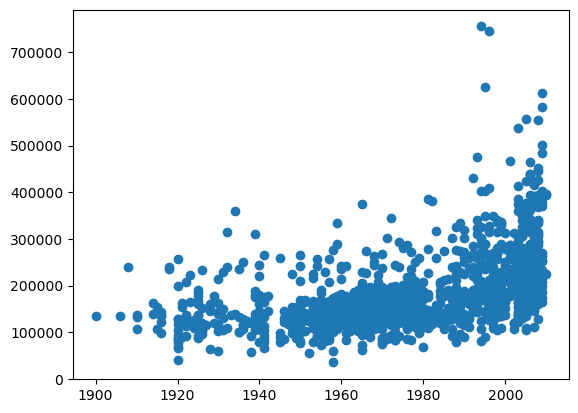

In [48]:
# We could fill these values with the mean year, only if it makes sense for the distribution,
# Or said differently, if there is enought density at the center to justify it.
# althought It would't make sense because if those datapoints don't have garage, we shouldn't fill it.
# But since the models have problems with null data, 
# I think we just should fill it so it makes the least impact in the prediction for those points.
X1data = np.array(X['GarageYrBlt'])
fig, ax = plt.subplots()
ax.scatter(X1data, y);

In [49]:
miss_row_indexes = X['GarageYrBlt'][X['GarageYrBlt'].isnull()==True]
imputer = SimpleImputer(strategy='mean') 
imputer.fit(np.array(X['GarageYrBlt']).reshape(-1,1))
imputed_data = imputer.transform(np.array(X['GarageYrBlt']).reshape(-1, 1))
# Le'ts try some of the indexes
imputed_data[1453], imputed_data[210]

(array([1978.50616389]), array([1978.50616389]))

In [50]:
imputed_data[X['GarageYrBlt'][X['GarageYrBlt'].isnull()==True].index]

array([[1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.50616389],
       [1978.506

In [51]:
# It is filling the missing values with 1978
for i in X['GarageYrBlt'][X['GarageYrBlt'].isnull()==True].index:
    X.loc[i, 'GarageYrBlt'] = imputed_data[i]

## Part 3: Testing our new features

In [52]:
# Get all our new filled columns names
null_sum = X[missing_values].isnull().sum()
new_columns = null_sum[null_sum == 0].index.tolist()
new_columns, len(new_columns)

(['MasVnrType',
  'MasVnrArea',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Electrical',
  'GarageType',
  'GarageYrBlt',
  'GarageFinish',
  'GarageQual',
  'GarageCond'],
 13)

### Concat old and new data, and apply the same process from the Part 1

In [53]:
# Save last values
X_num_old = X_num
X_cat_old = X_cat
numerical_columns_old = numerical_columns
categorical_columns_old = categorical_columns
print(numerical_columns, categorical_columns)
# Get all the data from the columns that was missing before
X_miss = X[new_columns]

# Select the numerical columns
numerical_columns = X_miss.select_dtypes(include=['int', 'float']).columns
X_num = X_miss.loc[:, numerical_columns]

# Select the categorical columns
categorical_columns = X_miss.select_dtypes(include=['object']).columns
X_cat = X_miss.loc[:, categorical_columns]

print('Numerical columns:', numerical_columns.size)
print('Categorical columns:', categorical_columns.size)
print('Total:', categorical_columns.size + numerical_columns.size, " Valid: ", X_miss.shape[1] == categorical_columns.size + numerical_columns.size)

Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object') Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating',
       'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')
Numerical columns: 2
Categorical colum

In [54]:
numerical_columns, categorical_columns

(Index(['MasVnrArea', 'GarageYrBlt'], dtype='object'),
 Index(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
        'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish',
        'GarageQual', 'GarageCond'],
       dtype='object'))

In [55]:
# Concatenate the data
numerical_columns = np.concatenate((numerical_columns_old, numerical_columns), axis=0)
categorical_columns = np.concatenate((categorical_columns_old, categorical_columns), axis=0)

numerical_columns, numerical_columns.shape, categorical_columns, categorical_columns.shape

(array(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
        'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MasVnrArea',
        'GarageYrBlt'], dtype=object),
 (36,),
 array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond',
        'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual',
        'Functional', 'PavedDrive', 'SaleType', 'SaleCondition',
  

In [56]:
X_num = X.loc[:, numerical_columns]
X_cat = X.loc[:, categorical_columns]
X_num.shape, X_cat.shape

((1460, 36), (1460, 38))

In [57]:
# Preprocess the numerical features
X_num = scaler.fit_transform(X_num)

# Encode the categorical features
X_cat = pd.get_dummies(X_cat)

print(X_num.shape, X_cat.shape)

(1460, 36) (1460, 243)


In [58]:
X_merged = pd.concat([pd.DataFrame(X_num, columns=numerical_columns), pd.DataFrame(X_cat)], axis=1)
X_merged.shape, X_merged.columns

((1460, 279),
 Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        ...
        'GarageQual_Gd', 'GarageQual_NA', 'GarageQual_Po', 'GarageQual_TA',
        'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_NA',
        'GarageCond_Po', 'GarageCond_TA'],
       dtype='object', length=279))

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_merged, y, test_size=0.2, random_state=0)

In [60]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 279) (292, 279) (1168,) (292,)


In [61]:
print(y_train.dtype, y_test.dtype)

int64 int64


In [62]:
# Reinstantiate the regressor
regressor = LinearRegression()

# Train the regression model
regressor.fit(X_train, y_train);

In [63]:
# Evaluate the performance of the model
y_pred = regressor.predict(X_test)
print(y_test.shape, y_test.shape)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

(292,) (292,)
Mean Squared Error: 82322944393199079947346378752.00
Mean Absolute Error: 30890498088763.52


In [64]:
# Baseline approach results
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0   200624.0   265840.0
 1   133000.0   144240.0
 2   110000.0   108072.0
 3   192000.0   209936.0
 4    88000.0    96024.0
 ..       ...        ...
 95  157000.0   156224.0
 96  213000.0   209936.0
 97  185000.0   160608.0
 98  124500.0   112272.0
 99  162900.0   160728.0
 
 [100 rows x 2 columns],
      Original  Predicted
 100  260000.0   245264.0
 101  198500.0   235784.0
 102  120000.0   118336.0
 103  159500.0   145456.0
 104  105900.0   105336.0
 ..        ...        ...
 195  142500.0   159224.0
 196   80000.0    61920.0
 197  145000.0   135176.0
 198  171000.0   169456.0
 199  122500.0   120120.0
 
 [100 rows x 2 columns],
      Original  Predicted
 200  139000.0   114520.0
 201  189000.0   206800.0
 202  120500.0   118200.0
 203  124000.0   128308.0
 204  160000.0   132084.0
 ..        ...        ...
 287  324000.0   299720.0
 288  555000.0   471464.0
 289  136000.0   251984.0
 290   82500.0   110668.0
 291  101000.0    96184.0
 
 [92 rows x 2 column

- So the error has gone worse, but on the other hand, this was just a simple test, the good thing is we have more features to consider.

## Part 4: Feature Selection

 - We've been using a simple regression model, but for a problem like this, there are better models that also offer more interpretability like Random Forests. But first, we'll use some feature selection methods, and see how much we can improve the accuracy of our model, and then see the difference between the regression one and the random forest.
 - Right now the training time is barely noticeable and we don't have a LOT of features, 279 doesn't seem too much right now, so we could probably use a greedier method instead of going with a filter method first, to see if we can reduce the features to a smaller number.
 - I have an assumption that maybe because a lot of features are used to describe a characteristic like for example the garage, all the garage features could be highly correlated, so we could remove many of those features OR create a new feature with them.
 - The method I would like to test is scikit-learn's Sequential Feature Selection, but first I would like to clean my feature s a little bit, and see if there are features that have very low variance (almost the same values in all observations).

In [65]:
from sklearn.feature_selection import VarianceThreshold
# Variance threshold of 5%
sel = VarianceThreshold(threshold=(0.05))
sel.feature_names_in_= X_merged.columns
print(X_merged.shape)
X_var = sel.fit_transform(X_merged)
print(X_var.shape)
selected_features = sel.get_support()
selected_columns = X_merged.columns[selected_features]
# So basically we've removed all features which had >=95% zeros in all observations

(1460, 279)
(1460, 124)


In [66]:
# Make the filtered X as df
X_var_df = pd.DataFrame(X_var, columns=selected_columns)

- Until now I've been looking at a feature, the first one "Id", I didn't want to arbitrarily remove it until now so if we can see if the feature selection method can remove it.

- Following what recommends the official page of Sequential Feature Selection https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py

- We use RidgeCV which is a Ridge regression model that includes cross validation (CV) for selecting the most important feature.
- Regression feature selection works by fitting a model and extracting the betas/coefficients of each feature.


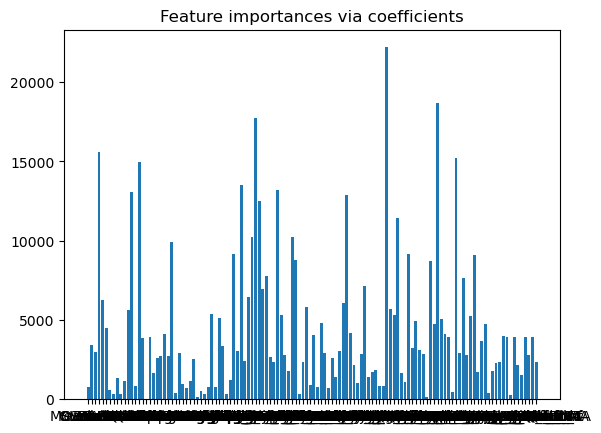

In [199]:
from sklearn.linear_model import RidgeCV
# 
ridge = RidgeCV().fit(X_var_df, y)
importance = np.abs(ridge.coef_) # Extract coefficients
plt.bar(height=importance, x=X_var_df.columns)
plt.title("Feature importances via coefficients")
plt.show()

- Which gives us the following top 5 features

In [200]:
# Make list of values
importance_features = list(zip(selected_columns, importance))

# Sort the list of tuples by values in descending order and select top 5 tuples
top5 = sorted(importance_features, key=lambda x: x[1], reverse=True)[:5]

# Extract column names from selected tuples
top5_features = [t[0] for t in top5]
top5_features

['KitchenQual_Ex',
 'BsmtQual_Ex',
 'Neighborhood_Edwards',
 'OverallQual',
 'BsmtExposure_Gd']

- Following the example instructions, we want to select the best features from the model, so then we can use the sequential feature selection which adds the next best feature

In [69]:
from sklearn.feature_selection import SelectFromModel

# Selects the threshold of the third best feature importance
threshold = np.sort(importance)[-3] + 0.01

tic = time.time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(X_var, y)
toc = time.time()

print(f"Features selected by SelectFromModel: {selected_columns[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: Index(['KitchenQual_Ex', 'BsmtQual_Ex'], dtype='object')
Done in 0.010s


- And now finally we use the SequentialFeatureSelector
- We can do a forward selection where we start with the 2 features and then we add 1 feature and see if the new subset improves or not, with backwards is the opposite

In [70]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time.time()
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=20, direction="forward"
).fit(X_var, y)
toc_fwd = time.time()

tic_bwd = time.time()
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=20, direction="backward"
).fit(X_var, y)
toc_bwd = time.time()

print(
    "Features selected by forward sequential selection: "
    f"{selected_columns[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Features selected by backward sequential selection: "
    f"{selected_columns[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by forward sequential selection: Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1',
       'GrLivArea', 'BsmtFullBath', 'Fireplaces', 'GarageCars', 'MSZoning_RM',
       'LotConfig_CulDSac', 'Neighborhood_Edwards', 'Neighborhood_NAmes',
       'Condition1_Norm', 'ExterQual_TA', 'KitchenQual_Ex', 'Functional_Typ',
       'BsmtQual_Ex', 'BsmtExposure_Gd', 'GarageType_NA'],
      dtype='object')
Done in 13.406s
Features selected by backward sequential selection: Index(['OverallQual', 'OverallCond', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath',
       'GarageCars', 'WoodDeckSF', 'LotConfig_CulDSac', 'Neighborhood_Edwards',
       'Neighborhood_OldTown', 'Condition1_Norm', 'BldgType_1Fam',
       'HouseStyle_1Story', 'ExterQual_TA', 'KitchenQual_Ex', 'Functional_Typ',
       'BsmtQual_Ex', 'BsmtExposure_Gd', 'BsmtFinType1_Unf', 'GarageCond_NA'],
      dtype='object')
Done in 145.455s


### Evaluation
- You see that? The feature selection method selected some features from the variables with missing values we fixed, so it was worth fixing!

- The columns we had with missing values were: 


      'MasVnrType',
      'MasVnrArea',
      'BsmtQual',
      'BsmtCond',
      'BsmtExposure',
      'BsmtFinType1',
      'BsmtFinType2',
      'Electrical',
      'GarageType',
      'GarageFinish',
      'GarageQual',
      'GarageCond'
  
- From this, we have BsmtQual_Ex, BsmtExposure_Gd, BsmtFinType1_Unf, GarageType_NA, in forward selection.
- And BsmtQual_Ex, BsmtExposure_Gd, BsmtFinType1_Unf, GarageCond_NA, for backward selection.
- Now let's train our model with these features.

In [71]:
features_forward = selected_columns[sfs_forward.get_support()]
features_backward = selected_columns[sfs_backward.get_support()]
X_forward = X_var_df[features_forward]
X_backward = X_var_df[features_backward]
X_forward.shape, X_backward.shape

((1460, 20), (1460, 20))

In [72]:
# Evaluate forward selection
X_train, X_test, y_train, y_test = train_test_split(X_forward, y, test_size=0.2, random_state=0)

In [73]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 20) (292, 20) (1168,) (292,)


In [74]:
print(y_train.dtype, y_test.dtype)

int64 int64


In [75]:
regressor = LinearRegression()
regressor.fit(X_train, y_train);

In [76]:
# Evaluate the performance of the model
y_pred = regressor.predict(X_test)
print(y_test.shape, y_test.shape)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1).astype(np.int64)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

(292,) (292,)
Mean Squared Error: 1782201882.20
Mean Absolute Error: 21333.85


In [77]:
# Baseline approach results
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0     200624     257179
 1     133000     158205
 2     110000     118350
 3     192000     213994
 4      88000      92680
 ..       ...        ...
 95    157000     151721
 96    213000     214065
 97    185000     160320
 98    124500     110949
 99    162900     148214
 
 [100 rows x 2 columns],
      Original  Predicted
 100    260000     240447
 101    198500     204820
 102    120000     113194
 103    159500     158206
 104    105900     112458
 ..        ...        ...
 195    142500     163264
 196     80000      45023
 197    145000     137548
 198    171000     178003
 199    122500     108219
 
 [100 rows x 2 columns],
      Original  Predicted
 200    139000     122741
 201    189000     194540
 202    120500      97257
 203    124000     126671
 204    160000     138034
 ..        ...        ...
 287    324000     284805
 288    555000     440641
 289    136000     190666
 290     82500     101432
 291    101000      95884
 
 [92 rows x 2 column

In [78]:
# Evaluate backward selection
X_train, X_test, y_train, y_test = train_test_split(X_backward, y, test_size=0.2, random_state=0)

In [79]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 20) (292, 20) (1168,) (292,)


In [80]:
print(y_train.dtype, y_test.dtype)

int64 int64


In [81]:
regressor = LinearRegression()

regressor.fit(X_train, y_train);

In [82]:
# Evaluate the performance of the model
y_pred = regressor.predict(X_test)
print(y_test.shape, y_test.shape)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1).astype(np.int64)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

(292,) (292,)
Mean Squared Error: 1624204072.95
Mean Absolute Error: 21294.15


In [83]:
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0     200624     260110
 1     133000     156223
 2     110000     120740
 3     192000     216703
 4      88000      92684
 ..       ...        ...
 95    157000     154204
 96    213000     215771
 97    185000     164172
 98    124500     113525
 99    162900     154298
 
 [100 rows x 2 columns],
      Original  Predicted
 100    260000     237327
 101    198500     200983
 102    120000     118599
 103    159500     153639
 104    105900     112800
 ..        ...        ...
 195    142500     163228
 196     80000      51600
 197    145000     148061
 198    171000     178543
 199    122500     117043
 
 [100 rows x 2 columns],
      Original  Predicted
 200    139000     123819
 201    189000     198792
 202    120500     102852
 203    124000     116973
 204    160000     146596
 ..        ...        ...
 287    324000     276874
 288    555000     430158
 289    136000     196856
 290     82500     109984
 291    101000     106812
 
 [92 rows x 2 column

- Now we are talking, it improved a lot, but still we are a bit off.
- Considering we have selected some features based on a simple selection based on a regression technique, going from 278 features to 123, to 20 seems like a big jump.
- We could try different feature selection methods, but let's try our new features with another model and see how it behaves, for example with Random Forests, which can be used also for feature selection.
- But firstable, I want to know, Why the House N_0 got a prediction 60k higher than the original? Maybe the model is saying something like "Oh, so you have a showerdoor? That's gotta be an expensive house, I'll add 60k more to the final price.", Which obviously sounds completely bonkers. The problem with this is we don't want to introduce bias into our training. This means, don't use the outputted results as a new input to make the error smaller, because it will affect the ability of our model for generalization and predict unseen data accurately.
- A way to visualize this in a linear regression model is to look at the coefficients.

In [84]:
features_backward.to_list()

['OverallQual',
 'OverallCond',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtFullBath',
 'GarageCars',
 'WoodDeckSF',
 'LotConfig_CulDSac',
 'Neighborhood_Edwards',
 'Neighborhood_OldTown',
 'Condition1_Norm',
 'BldgType_1Fam',
 'HouseStyle_1Story',
 'ExterQual_TA',
 'KitchenQual_Ex',
 'Functional_Typ',
 'BsmtQual_Ex',
 'BsmtExposure_Gd',
 'BsmtFinType1_Unf',
 'GarageCond_NA']

In [85]:
coefficients = regressor.coef_
intercept = regressor.intercept_

manual_prediction = np.dot(X_test, coefficients) + intercept

print('Predicted value:', y_pred[0])
print('Manual prediction:', manual_prediction[0])
print('House N_0:', np.array(X_test)[0])
print('Coefficients', coefficients)
print('Intercept:', intercept)
print('Dot product[0]: ', np.dot(X_test, coefficients)[0])

reg_coef_data = pd.DataFrame(pd.concat([pd.DataFrame(np.array(X_test)[0]).T, pd.DataFrame(coefficients).T], axis=0))
reg_coef_data.columns = features_backward
reg_coef_data

Predicted value: 260110.16520017516
Manual prediction: 260110.16520017516
House N_0: [-0.07183611 -2.31508485  3.49942984 -0.79516323  1.10781015  0.31172464
 -0.75217584  1.          0.          0.          1.          1.
  1.          0.          0.          0.          0.          0.
  0.          0.        ]
Coefficients [ 19475.06553726   5062.87231804  27074.97144586  25773.0574573
   4429.17308278  10596.26891409   3164.92445117  13632.16689855
 -12381.73089462 -16806.11431005  14174.5538513   17373.66174043
   8858.91058393 -17112.54866921  34710.10616493  18335.77914267
  36244.42719535  22673.84323266  -9232.99827225  14501.15627744]
Intercept: 139108.4672923262
Dot product[0]:  121001.69790784895


,OverallQual,OverallCond,1stFlrSF,2ndFlrSF,BsmtFullBath,GarageCars,WoodDeckSF,LotConfig_CulDSac,Neighborhood_Edwards,Neighborhood_OldTown,Condition1_Norm,BldgType_1Fam,HouseStyle_1Story,ExterQual_TA,KitchenQual_Ex,Functional_Typ,BsmtQual_Ex,BsmtExposure_Gd,BsmtFinType1_Unf,GarageCond_NA
0,-0.071836,-2.315085,3.499430,-0.795163,1.107810,0.311725,-0.752176,1.000000,0.000000,0.00000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,19475.065537,5062.872318,27074.971446,25773.057457,4429.173083,10596.268914,3164.924451,13632.166899,-12381.730895,-16806.11431,14174.553851,17373.66174,8858.910584,-17112.548669,34710.106165,18335.779143,36244.427195,22673.843233,-9232.998272,14501.156277


- Let's take a look at the data from house N_0 (first row) and the coefficients (second row).
- Consider that the intercept value is 139108.46
- The feature that the model rates the highest is the BsmtQual_Ex with 36244.42 and the lowest one is ExterQual_TA with -17112.54.
- Just by having a basement with excelent quality, it adds 36k to the price, and if the External quality is typical (slight dampness allowed), it substracts 17k from the price.
- We can see that most negative coefficient values are not taken into account, which in some way is like saying that the features that the model knows it would reduce the price didn't got taken in account because the observation had 0 in every categorical data that it calculated.
- And this tells us that it's not enough features for this model to generalize in scenarios like this.

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
# Training RF with X_backward
forest = RandomForestRegressor()
forest.fit(X_train, y_train);

In [87]:
X_train.shape

(1168, 20)

In [88]:
# Evaluate the performance of the model
y_pred = forest.predict(X_test)
print(y_test.shape, y_test.shape)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1).astype(np.int64)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

(292,) (292,)
Mean Squared Error: 966193251.45
Mean Absolute Error: 19923.73


In [89]:
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0     200624     208036
 1     133000     144486
 2     110000     113338
 3     192000     216269
 4      88000      90410
 ..       ...        ...
 95    157000     144885
 96    213000     213676
 97    185000     136809
 98    124500     123287
 99    162900     133599
 
 [100 rows x 2 columns],
      Original  Predicted
 100    260000     258490
 101    198500     223924
 102    120000     145674
 103    159500     160158
 104    105900     119893
 ..        ...        ...
 195    142500     155807
 196     80000      77450
 197    145000     154283
 198    171000     193370
 199    122500     146756
 
 [100 rows x 2 columns],
      Original  Predicted
 200    139000     141552
 201    189000     219346
 202    120500     120541
 203    124000     105702
 204    160000     147352
 ..        ...        ...
 287    324000     272352
 288    555000     536631
 289    136000     200634
 290     82500      85451
 291    101000      95848
 
 [92 rows x 2 column

- So the model is not improving, at this point I think I should look more at the data, so I'll plot the top 5 features from the list.
- But how do I plot the binary categorical data? We can do it by plotting the different combinations of those versus the price target and see how they interact with the price.

In [90]:
X_backward[top5_features]

,KitchenQual_Ex,BsmtQual_Ex,Neighborhood_Edwards,OverallQual,BsmtExposure_Gd
0,0.0,0.0,0.0,0.651479,0.0
1,0.0,0.0,0.0,-0.071836,1.0
2,0.0,0.0,0.0,0.651479,0.0
3,0.0,0.0,0.0,0.651479,0.0
4,0.0,0.0,0.0,1.374795,0.0
...,...,...,...,...,...
1455,0.0,0.0,0.0,-0.071836,0.0
1456,0.0,0.0,0.0,-0.071836,0.0
1457,0.0,0.0,0.0,0.651479,0.0
1458,0.0,0.0,0.0,-0.795151,0.0


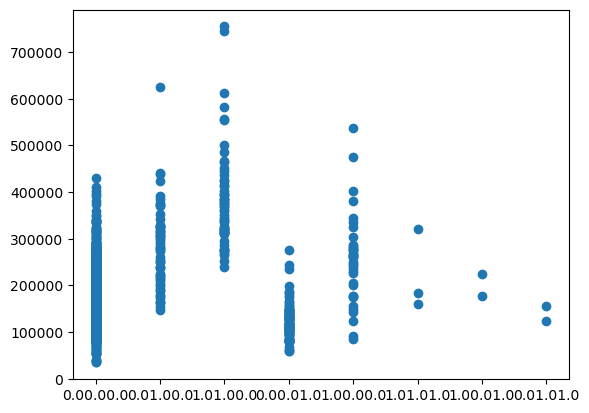

In [91]:
cat_features = ["KitchenQual_Ex", "BsmtQual_Ex", "Neighborhood_Edwards"]
data = X_backward[cat_features]

def get_binary_features(data, cat_features):
    binary_features = []
    for i in range(data.shape[0]):
        value = ""
        for f in cat_features:
            value += str(data[f][i])
        binary_features.append(value)
        value = ""
    return np.array(binary_features)

binary_features = get_binary_features(data, cat_features)

fig, ax = plt.subplots()
ax.scatter(binary_features, y);

- So just looking at it we can see that most of the lower price range houses don't have any of the features described above, the kitchen quality is not excelent, que basement quality is not excelent, and the neighborhood is not edwards
- While the houses of the most higher price range, have both the first qualities, but are not in the edwards neighborhood.
- Now I wanna see all neighborhoods that got selected.


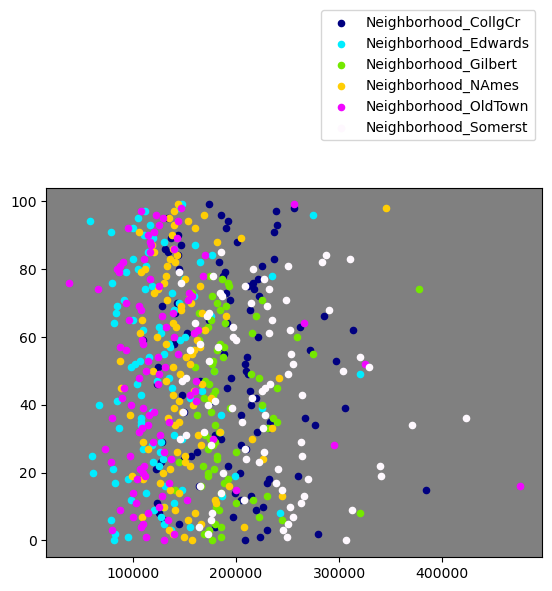

In [92]:
neighborhoods = [n for n in X_var_df.columns if 'Neighborhood' in n]
neigh_ones = []
for n in neighborhoods:
    neigh_ones.append(y[X_var_df[X_var_df[n] == 1][:100].index])
    
fig, ax = plt.subplots()
index = 0
colors = cm.gist_ncar(np.linspace(0, 1, len(neigh_ones)))
for no, c in zip(neigh_ones, colors):
    ax.scatter(no, range(len(no)), label=neighborhoods[index], color=colors[index], s=20)
    index+=1
ax.set_facecolor((0.5,0.5,0.5))
ax.legend(loc='upper right', bbox_to_anchor=(1,1.5));

- I was thinking on considering more neighborhoods in the features, because seems like neighborhoods can give you a solid window of prices like different areas of prices.
- Said this, neighborhood seem to only reflect the houses from the lower end 100k-300k.

['KitchenAbvGr', 'KitchenQual_Ex', 'KitchenQual_Gd', 'KitchenQual_TA']


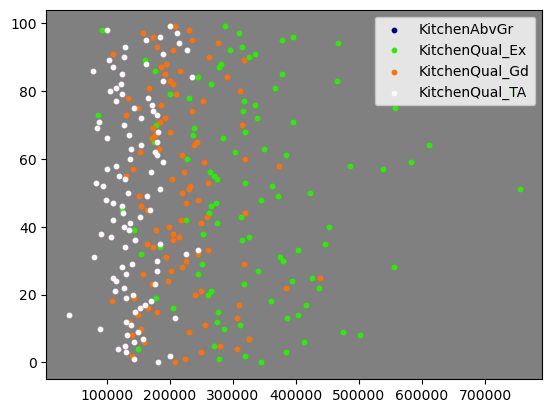

In [93]:
kitchens = [n for n in X_var_df.columns if 'Kitchen' in n]
kitchen_ones = []
print(kitchens)
for n in kitchens:
    kitchen_ones.append(y[X_var_df[X_var_df[n] == 1][:100].index])
    
fig, ax = plt.subplots()
index = 0
colors = cm.gist_ncar(np.linspace(0, 1, len(kitchen_ones)))
for no, c in zip(kitchen_ones, colors):
    ax.scatter(no, range(len(no)), label=kitchens[index], color=colors[index], s=10)
    index+=1
ax.set_facecolor((0.5,0.5,0.5))
ax.legend(loc='upper right');

- KitchenQual_Ex has more observations out of all kitchen features and naturally it would be a good feature, because we have a lot of data for the lower priced houses, and not for the expensive ones, the same for Good quality.

['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_Unf']


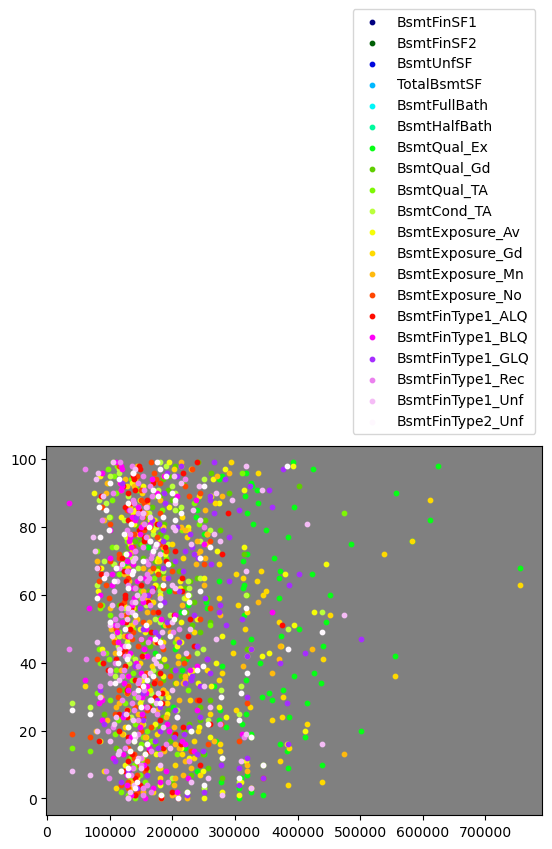

In [94]:
basements = [n for n in X_var_df.columns if 'Bsmt' in n ] 
basement_ones = []

print(basements)
for n in basements:
    basement_ones.append(y[X_var_df[X_var_df[n] == 1][:100].index])
    
fig, ax = plt.subplots()
index = 0
colors = cm.gist_ncar(np.linspace(0, 1, len(basement_ones)))
for no, c in zip(basement_ones, colors):
    ax.scatter(no, range(len(no)), label=basements[index], color=colors[index], s=10)
    index+=1
ax.set_facecolor((0.5,0.5,0.5))
ax.legend(loc='upper right', bbox_to_anchor=(1, 2.2));

- Again, the sames applies to BsmtQual_Ex, it is a little more spread to the high end price houses than the other features.
- Now let's see how behaves numerical data.
- The top feature in backward sequential feature selection is OverallQual, so let's see that.

In [95]:
# There are two features that are a general appreciation of the house state
overall = [n for n in X_var_df.columns if 'Overall' in n]
overall

['OverallQual', 'OverallCond']

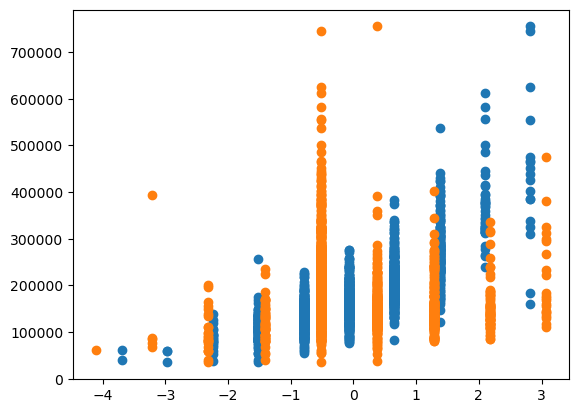

In [96]:
X1data = np.array(X_var_df['OverallQual'])
X2data = np.array(X_var_df['OverallCond'])
fig, ax = plt.subplots()
ax.scatter(X1data, y);
ax.scatter(X2data, y);

- Clearly, OverallQual has a better spread of the data because OverallCond has more density at the center, meaning that many houses are given very similar score.
- So let's test OverallQual with some other features with numerical data.

In [97]:
numerical_features = []
for x in features_backward:
    if X_var_df[x].dtype == 'float64' and '_' not in x: # Encoded features have underscore
        numerical_features.append(x)
numerical_features

['OverallQual',
 'OverallCond',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtFullBath',
 'GarageCars',
 'WoodDeckSF']

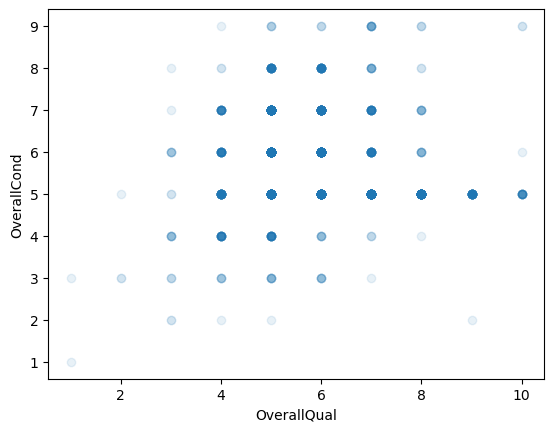

In [98]:
# Plotting with alpha=0.1 to see where is the areas of highed density of points.
# This one is easier to plot because they're both ratings from 1-10 so I use X instead of X_var_df with scaled data.
fig, ax = plt.subplots()
x_axis = numerical_features[0]
y_axis = numerical_features[1]
ax.scatter(X[x_axis], X[y_axis], alpha=0.1);
plt.xlabel(x_axis);
plt.ylabel(y_axis);

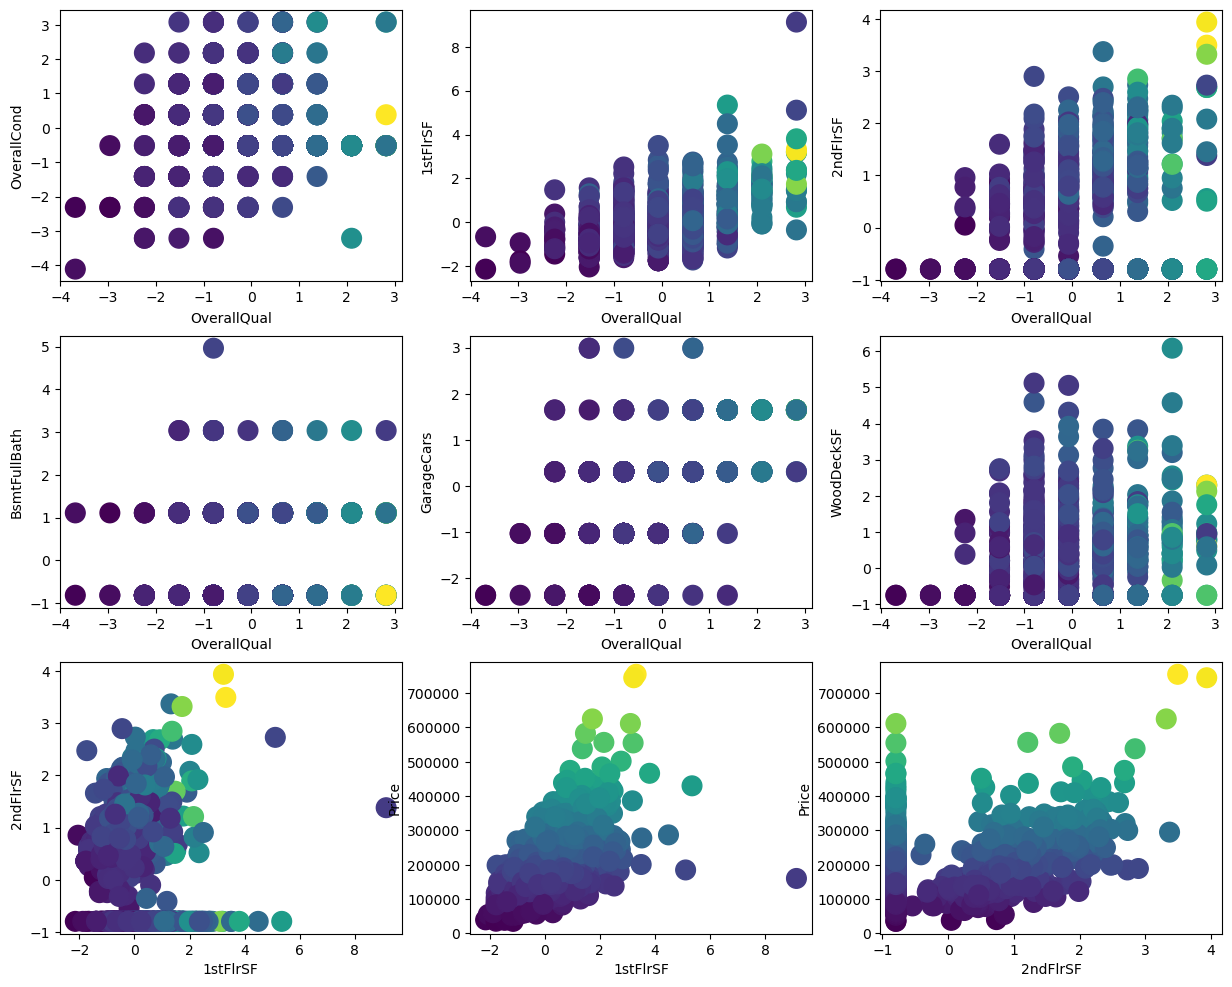

In [99]:
# How features interact
# Y and X are features, Color is price, the cooler the lowest price, the yellower the highest price.
fig, axs = plt.subplots(3, 3, figsize=(15,12))

colors = cm.gist_ncar(np.linspace(0, 1,  min(y)))

x_axis = numerical_features[0]
y_axis = numerical_features[1]
axs[0, 0].scatter(X_var_df[x_axis], X_var_df[y_axis], s=200, c=y);
axs[0, 0].set_xlabel(x_axis);
axs[0, 0].set_ylabel(y_axis);

x_axis = numerical_features[0]
y_axis = numerical_features[2]
axs[0, 1].scatter(X_var_df[x_axis], X_var_df[y_axis], s=200, c=y);
axs[0, 1].set_xlabel(x_axis);
axs[0, 1].set_ylabel(y_axis);

x_axis = numerical_features[0]
y_axis = numerical_features[3]
axs[0, 2].scatter(X_var_df[x_axis], X_var_df[y_axis], s=200, c=y);
axs[0, 2].set_xlabel(x_axis);
axs[0, 2].set_ylabel(y_axis);

x_axis = numerical_features[0]
y_axis = numerical_features[4]
axs[1, 0].scatter(X_var_df[x_axis], X_var_df[y_axis], s=200, c=y);
axs[1, 0].set_xlabel(x_axis);
axs[1, 0].set_ylabel(y_axis);

x_axis = numerical_features[0]
y_axis = numerical_features[5]
axs[1, 1].scatter(X_var_df[x_axis], X_var_df[y_axis],s=200, c=y);
axs[1, 1].set_xlabel(x_axis);
axs[1, 1].set_ylabel(y_axis);

x_axis = numerical_features[0]
y_axis = numerical_features[6]
axs[1, 2].scatter(X_var_df[x_axis], X_var_df[y_axis], s=200, c=y);
axs[1, 2].set_xlabel(x_axis);
axs[1, 2].set_ylabel(y_axis);

# Some other obvs

x_axis = numerical_features[2]
y_axis = numerical_features[3]
axs[2, 0].scatter(X_var_df[x_axis], X_var_df[y_axis], s=200, c=y);
axs[2, 0].set_xlabel(x_axis);
axs[2, 0].set_ylabel(y_axis);

x_axis = numerical_features[2]
axs[2, 1].scatter(X_var_df[x_axis], y, s=200, c=y);
axs[2, 1].set_xlabel(x_axis);
axs[2, 1].set_ylabel('Price');

x_axis = numerical_features[3]
axs[2, 2].scatter(X_var_df[x_axis], y, s=200, c=y);
axs[2, 2].set_xlabel(x_axis);
axs[2, 2].set_ylabel('Price');

- We already used a regression model to select features. Now I want to try a decision tree based feature selection and also a different loss function.
- Also we don't have too much features so we could use an approach to get the numbers of features estimated dynamically instead of providing it as a parameter.

### Selecting Features using ExtraTrees
- By extracting the feature importances of the decision trees we an also select the best performing features that are the ones at the top of the trees.

In [100]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier()
clf.fit(X_var_df, y)

print(clf.feature_importances_.shape)
print(X_var_df.shape)

# Use SelectFromModel to select the most important features
sfm = SelectFromModel(clf)
X_selected = sfm.fit_transform(X_var_df, y)
print(X_selected.shape)
X_var_df.columns[sfm.get_support()]

(124,)
(1460, 124)
(1460, 42)


Index(['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold',
       'MasVnrArea', 'GarageYrBlt', 'LotShape_IR1', 'LotShape_Reg',
       'LotConfig_Corner', 'LotConfig_Inside', 'HouseStyle_1Story',
       'RoofStyle_Gable', 'HeatingQC_Ex', 'HeatingQC_TA', 'MasVnrType_BrkFace',
       'MasVnrType_None', 'BsmtExposure_Av', 'BsmtExposure_No',
       'BsmtFinType1_GLQ', 'BsmtFinType1_Unf', 'GarageFinish_RFn'],
      dtype='object')

In [101]:
selected_cols = X_var_df.columns[sfm.get_support()]
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Make list of values
importance_features = list(zip(selected_cols, importance))

# Sort the list of tuples by values in descending order and select top 5 tuples
top_f_importance = sorted(importance_features, key=lambda x: x[1], reverse=True)
top_f_df = pd.DataFrame(top_f_importance).T
top_f = [t[0] for t in top_f_importance]
print(top_f[:10])
top_f_df

['OverallQual', 'FullBath', 'GrLivArea', 'MoSold', 'BsmtFinType1_Unf', 'OverallCond', '2ndFlrSF', 'HeatingQC_TA', 'MasVnrType_None', 'YearBuilt']


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,OverallQual,FullBath,GrLivArea,MoSold,BsmtFinType1_Unf,OverallCond,2ndFlrSF,HeatingQC_TA,MasVnrType_None,YearBuilt,...,LotShape_IR1,YearRemodAdd,HouseStyle_1Story,YrSold,BsmtFinSF1,TotalBsmtSF,RoofStyle_Gable,BsmtExposure_No,LotConfig_Inside,BedroomAbvGr
1,15590.241186,14952.158952,13089.286593,9898.387585,9124.150983,6282.86743,5650.47211,5397.634375,5106.73748,4503.150564,...,717.811947,556.497078,518.739814,360.328581,335.166407,329.018258,306.332039,298.138787,116.977187,22.204457


In [102]:
print(top_f_importance[:10])

[('OverallQual', 15590.241185935913), ('FullBath', 14952.158952259051), ('GrLivArea', 13089.28659258569), ('MoSold', 9898.387585006189), ('BsmtFinType1_Unf', 9124.15098330892), ('OverallCond', 6282.867429810747), ('2ndFlrSF', 5650.47210992912), ('HeatingQC_TA', 5397.634375095047), ('MasVnrType_None', 5106.737479575715), ('YearBuilt', 4503.150564009324)]


- So we used a different method for feature selections called ExtraTreesClassifier which select fatures on an impurity-based feature importance.
- We went from 278 to 123 features, and the top 5 seems about the same on the other selection methods.

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_var_df[selected_columns], y, test_size=0.2, random_state=0)

In [104]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1168, 124) (292, 124) (1168,) (292,)


In [105]:
# Reinstantiate the regressor
regressor = LinearRegression()

# Train the regression model
regressor.fit(X_train, y_train);

In [106]:
# Evaluate the performance of the model
y_pred = regressor.predict(X_test)
y_train_pred = regressor.predict(X_train)

results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

results_train = pd.DataFrame(
    np.concatenate(
        (
            y_train.to_numpy().reshape(len(y_train), 1),
            y_train_pred.reshape(len(y_train_pred), 1)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

# If the model predicts the train data with 0 error, it's overfitting.

mse2 = mean_squared_error(y_train, y_train_pred)
mae2 = mean_absolute_error(y_train, y_train_pred)

print(f'Mean Squared Error Train: {mse2:0.2f}')
print(f'Mean Absolute Error Train: {mae2:0.2f}')

Mean Squared Error: 2029740908.86
Mean Absolute Error: 22118.68
Mean Squared Error Train: 686659014.26
Mean Absolute Error Train: 17101.08


In [107]:
# Baseline approach results
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0   200624.0   212336.0
 1   133000.0   152912.0
 2   110000.0   103264.0
 3   192000.0   219280.0
 4    88000.0    80864.0
 ..       ...        ...
 95  157000.0   158688.0
 96  213000.0   213008.0
 97  185000.0   161200.0
 98  124500.0   116032.0
 99  162900.0   156320.0
 
 [100 rows x 2 columns],
      Original  Predicted
 100  260000.0   243632.0
 101  198500.0   212400.0
 102  120000.0   114272.0
 103  159500.0   122640.0
 104  105900.0   115216.0
 ..        ...        ...
 195  142500.0   164704.0
 196   80000.0    68992.0
 197  145000.0   144848.0
 198  171000.0   176368.0
 199  122500.0   105248.0
 
 [100 rows x 2 columns],
      Original  Predicted
 200  139000.0   104400.0
 201  189000.0   172912.0
 202  120500.0   124336.0
 203  124000.0    93296.0
 204  160000.0   132976.0
 ..        ...        ...
 287  324000.0   290080.0
 288  555000.0   445392.0
 289  136000.0   186016.0
 290   82500.0   103504.0
 291  101000.0   113872.0
 
 [92 rows x 2 column

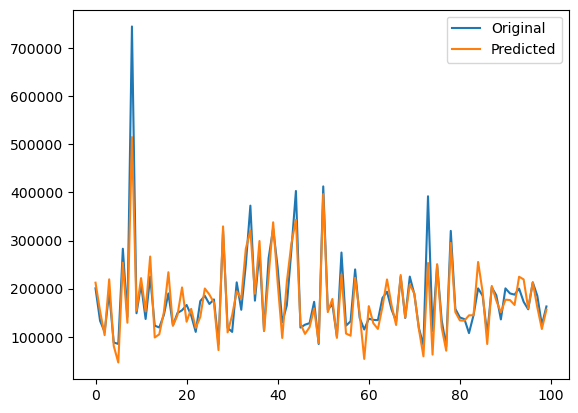

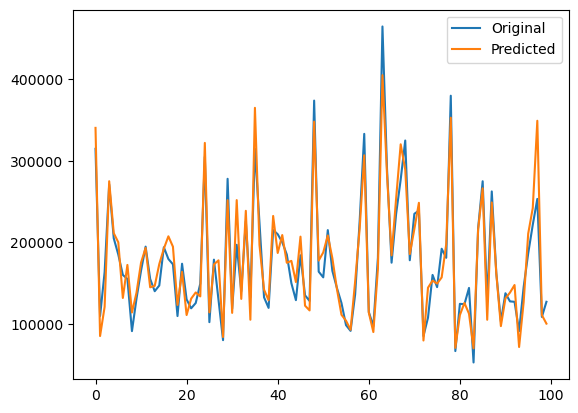

In [108]:
# Test Data
pd.DataFrame(results)[:100].plot();
# Train Data to see if it's not overfitting
pd.DataFrame(results_train)[:100].plot();

- We can see that the model is not overfitting the train data, It obviously is performing better than test, but at least is not memorizing it. Different story would be if we performed worse than test data, but it's not the case.

In [109]:
#forest = RandomForestClassifier()
forest = RandomForestRegressor()
forest.fit(X_train, y_train);

In [110]:
# Evaluate the performance of the model
y_pred = forest.predict(X_test)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1).astype(np.int64)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

Mean Squared Error: 1130447494.16
Mean Absolute Error: 17970.00


In [111]:
results[0:100], results[100:200], results[200:]

(    Original  Predicted
 0     200624     212209
 1     133000     149280
 2     110000     105941
 3     192000     221767
 4      88000      91902
 ..       ...        ...
 95    157000     151672
 96    213000     204894
 97    185000     167686
 98    124500     117212
 99    162900     142944
 
 [100 rows x 2 columns],
      Original  Predicted
 100    260000     245092
 101    198500     225787
 102    120000     117037
 103    159500     162473
 104    105900     111196
 ..        ...        ...
 195    142500     144499
 196     80000      89973
 197    145000     130310
 198    171000     168095
 199    122500     133386
 
 [100 rows x 2 columns],
      Original  Predicted
 200    139000     137135
 201    189000     209848
 202    120500     115140
 203    124000     122169
 204    160000     136596
 ..        ...        ...
 287    324000     291844
 288    555000     434729
 289    136000     162285
 290     82500      80382
 291    101000      87214
 
 [92 rows x 2 column

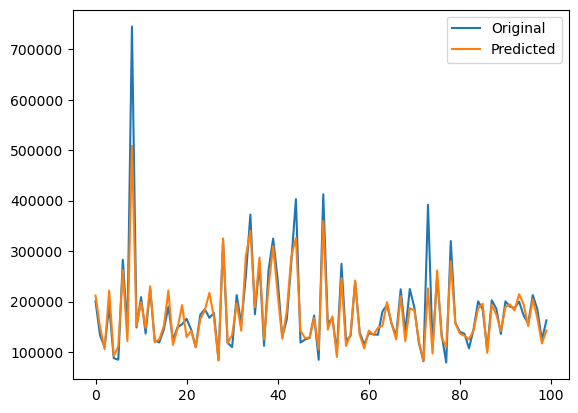

In [112]:
pd.DataFrame(results)[:100].plot();

- By using over 100 more features we didn't improve the model performance. So it can be either the model we're using, not being able to learn, the quality of the features, maybe our model bias is too strong and we are overfitting the data, not being able to generalize the test data. So how do we measure that?
- Cross validation can be used for this purpose and see if the model can generalize to new data.

In [183]:
# Create a general function for the model
def testModel(X_train, X_test, y_train, y_test, modelClass):
    model = modelClass()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    return [mse, mae]

In [114]:
from sklearn.model_selection import KFold
X_kf = np.array(X_var_df)
kf = KFold(n_splits=10)
rf_output = []
lr_output = []
for train, test in kf.split(X_kf):
    X_train, X_test, y_train, y_test = X_kf[train], X_kf[test], y[train], y[test]
    rf = testModel(X_train, X_test, y_train, y_test, RandomForestRegressor)
    lr = testModel(X_train, X_test, y_train, y_test, LinearRegression)
    rf_output.append(rf)
    lr_output.append(lr)
    print("Random Forest: ", rf)
    print("Linear Regression: ", lr)

Random Forest:  [652087168.1686541, 17193.909383561644]
Linear Regression:  [765294168.0547945, 22156.54794520548]
Random Forest:  [690312767.7275213, 17898.66773972603]
Linear Regression:  [899351428.869863, 21613.445205479453]
Random Forest:  [502774138.56060344, 15949.68609589041]
Linear Regression:  [712999408.5449486, 19459.717465753423]
Random Forest:  [1445628057.3808827, 19198.613356164384]
Linear Regression:  [1719278039.1780822, 22139.739726027397]
Random Forest:  [1067967874.2429432, 18758.484315068494]
Linear Regression:  [1430493662.9931507, 22872.842465753423]
Random Forest:  [646049877.85785, 14991.815410958903]
Linear Regression:  [768707720.1438357, 17369.554794520547]
Random Forest:  [595855281.5611129, 15979.978287671234]
Linear Regression:  [731117589.6027397, 18594.35616438356]
Random Forest:  [555484630.9830925, 16016.774178082194]
Linear Regression:  [957910215.4657534, 22420.27397260274]
Random Forest:  [1666267137.2759395, 20610.923698630137]
Linear Regression:

In [115]:
X_var_df.shape

(1460, 124)

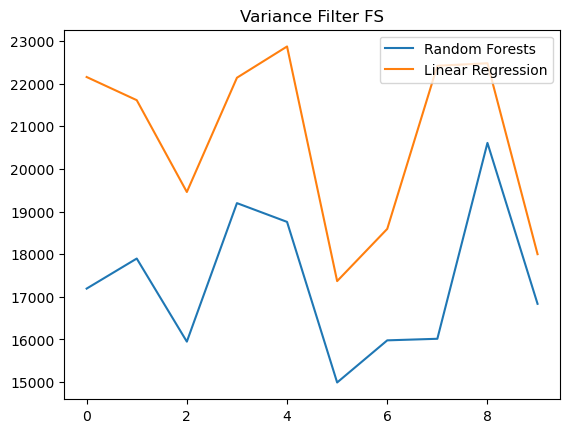

In [116]:
# Mae results RF vs LR
results = pd.DataFrame(
    pd.concat(
        (pd.DataFrame(rf_output)[1], pd.DataFrame(lr_output)[1]), 
        axis=1)
);
fig, ax = plt.subplots()
ax.plot(range(len(results)), results, label=["Random Forests", "Linear Regression"]);
ax.set_title(label="Variance Filter FS");
ax.legend(loc='upper right');

In [117]:
print("Average MAE RF:", f"{np.array(rf_output)[:,1].sum()/len(rf_output):0.2f}")
print("Average MAE LR:", f"{np.array(lr_output)[:,1].sum()/len(lr_output):0.2f}")

Average MAE RF: 17343.55
Average MAE LR: 20710.76


- Now I want to test some fixes in the feature selection. The thing is, from the selected features, there is the feature Id which obviously is an arbitrary number, and this tell us that all the features with the same or lower importance than Id could be removed.

In [118]:
no_id_features = top_f_importance[:top_f.index("Id")]
no_id_features = [cf[0] for cf in no_id_features]
len(top_f_importance), len(no_id_features)

(42, 30)

In [119]:
X_kf = np.array(X_var_df[no_id_features])
kf = KFold(n_splits=10)
rf_output = []
lr_output = []
for train, test in kf.split(X_kf):
    X_train, X_test, y_train, y_test = X_kf[train], X_kf[test], y[train], y[test]
    rf = testModel(X_train, X_test, y_train, y_test, RandomForestRegressor)
    lr = testModel(X_train, X_test, y_train, y_test, LinearRegression)
    rf_output.append(rf)
    lr_output.append(lr)
    print("Random Forest: ", rf)
    print("Linear Regression: ", lr)

Random Forest:  [677312540.9483699, 17812.696712328765]
Linear Regression:  [836020746.9535733, 22281.09050925342]
Random Forest:  [785744396.1064625, 19075.895958904108]
Linear Regression:  [892009639.6738083, 20948.063461328977]
Random Forest:  [551152208.8928419, 17082.68979452055]
Linear Regression:  [779038267.0754828, 21363.98829664738]
Random Forest:  [1504868808.1899142, 19888.143630136983]
Linear Regression:  [1831722788.4220672, 23890.9012323337]
Random Forest:  [1172943253.600837, 20896.13904109589]
Linear Regression:  [1614613048.1750014, 25060.121190262536]
Random Forest:  [657173536.1765014, 15294.13821917808]
Linear Regression:  [1174828771.599062, 19625.724738937613]
Random Forest:  [563455310.0943803, 15856.845273972604]
Linear Regression:  [942122214.0632995, 20545.541253761934]
Random Forest:  [666434788.6859055, 17551.547808219177]
Linear Regression:  [934853299.17721, 20691.21587476635]
Random Forest:  [2012778850.2570102, 22224.741712328767]
Linear Regression:  [3

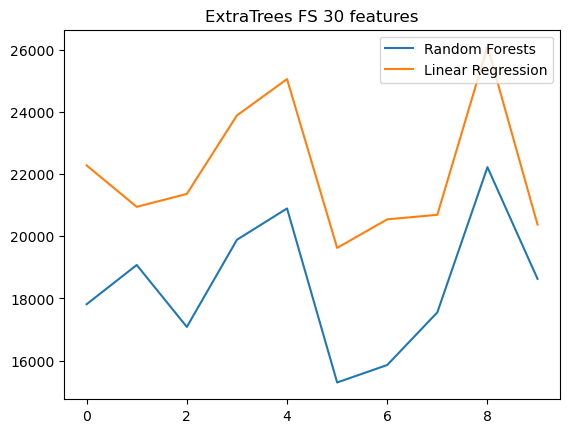

In [120]:
results = pd.DataFrame(
    pd.concat(
        (pd.DataFrame(rf_output)[1], pd.DataFrame(lr_output)[1]), 
        axis=1)
);
fig, ax = plt.subplots()
ax.plot(range(len(results)), results, label=["Random Forests", "Linear Regression"]);
ax.set_title(label="ExtraTrees FS " + str(len(no_id_features)) + " features");
ax.legend(loc='upper right');

In [121]:
print("Average MAE RF:", f"{np.array(rf_output)[:,1].sum()/len(rf_output):0.2f}")
print("Average MAE LR:", f"{np.array(lr_output)[:,1].sum()/len(lr_output):0.2f}")

Average MAE RF: 18431.21
Average MAE LR: 22089.17


- Clearly removing the features with less importance than Id led to poor results, so I can assume that we shoul only remove Id and let the others.
- Ok, before we try more methods, Since we checked that by removing the feature Id actually made the model improve a bit, means that the model is learning on noisy data and thus on unseed data performs poorly due to overfittin. A simple way to prove this, is testing on target train data and see if the model has 0% error.

In [122]:
# Remove only Id
no_id_features = [cf[0] for cf in top_f_importance if cf[0] != 'Id']
len(top_f_importance), len(no_id_features)

(42, 41)

In [123]:
X_kf = np.array(X_var_df[no_id_features])
kf = KFold(n_splits=10)
rf_output = []
lr_output = []
for train, test in kf.split(X_kf):
    X_train, X_test, y_train, y_test = X_kf[train], X_kf[test], y[train], y[test]
    rf = testModel(X_train, X_test, y_train, y_test, RandomForestRegressor)
    lr = testModel(X_train, X_test, y_train, y_test, LinearRegression)
    rf_output.append(rf)
    lr_output.append(lr)
    print("Random Forest: ", rf)
    print("Linear Regression: ", lr)

Random Forest:  [664131252.9788232, 17279.93315068493]
Linear Regression:  [743738499.7146721, 20560.784684140734]
Random Forest:  [754363360.5827382, 18508.368356164385]
Linear Regression:  [858548902.1086788, 20783.68939761185]
Random Forest:  [504808564.71693015, 15823.301232876714]
Linear Regression:  [701163329.8421545, 20270.787418874854]
Random Forest:  [1636605766.6209123, 19499.79301369863]
Linear Regression:  [1803823213.0327694, 23105.72174377946]
Random Forest:  [1033550365.6619252, 18952.457465753425]
Linear Regression:  [1561095774.6491306, 24229.237855303985]
Random Forest:  [697908312.2444507, 14794.340136986299]
Linear Regression:  [1060626440.4267616, 18805.429635068536]
Random Forest:  [575646302.8182931, 15934.206849315067]
Linear Regression:  [844861962.4684902, 19757.393466337086]
Random Forest:  [577405844.279485, 16234.594109589043]
Linear Regression:  [817405565.8580427, 19642.718648888145]
Random Forest:  [1933654963.0681503, 22293.034178082195]
Linear Regress

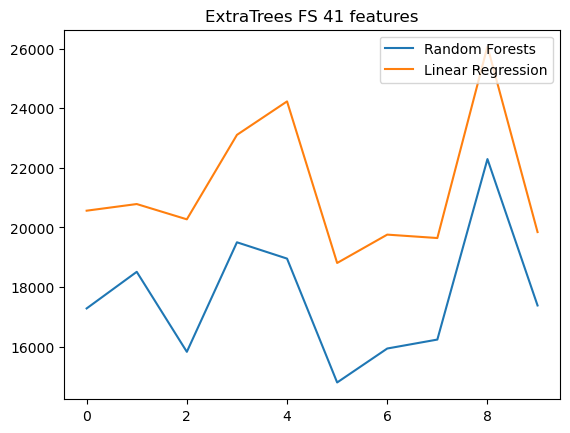

In [124]:
results = pd.DataFrame(
    pd.concat(
        (pd.DataFrame(rf_output)[1], pd.DataFrame(lr_output)[1]), 
        axis=1)
);
fig, ax = plt.subplots()
ax.plot(range(len(results)), results, label=["Random Forests", "Linear Regression"]);
ax.set_title(label="ExtraTrees FS " + str(len(no_id_features)) + " features");
ax.legend(loc='upper right');

In [125]:
print("Average MAE RF:", f"{np.array(rf_output)[:,1].sum()/len(rf_output):0.2f}")
print("Average MAE LR:", f"{np.array(lr_output)[:,1].sum()/len(lr_output):0.2f}")

Average MAE RF: 17669.93
Average MAE LR: 21307.12


- So, the other features did help the model a little.
- But still this error is too high

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X_var_df[selected_columns], y, test_size=0.2, random_state=0)
print('RF: Train & Train', testModel(X_train, X_train, y_train, y_train, RandomForestRegressor))
print('RF: Train & Test', testModel(X_train, X_test, y_train, y_test, RandomForestRegressor))
print('LR: Train & Train', testModel(X_train, X_train, y_train, y_train, LinearRegression))
print('LR: Train & Test', testModel(X_train, X_test, y_train, y_test, LinearRegression))

RF: Train & Train [119667094.71081412, 6504.328450342467]
RF: Train & Test [1085398529.6226664, 17575.76359589041]
LR: Train & Train [686659014.2585616, 17101.080479452055]
LR: Train & Test [2029740908.8630137, 22118.68493150685]


- Tested to see if the model was overfitting, and gave me 6.6k on RF, and before some tests I got 0 error so we'll stick with this, If after doing all the selection we still don't achieve better results on test and on train get's lower and lower, we might have to include a "Rare feature", or some other technique to reduce even more overfitting.
- To deal with the overfitting problem, a natural way of doing this is getting more diverse data so the model could drop learning from the noise in pressence of more general data, but because we only have the data provided in the challegenge, we cannot expect more data.
- Another way would be Regularization. We can reward the model if the training goes well, but also we can Penalize the model if it becomes too complex.
- Some regularization techniques are: Ridge (L2), Lasso (L1), ElasticNet (L1 and L2 combined), Dropout (on Neural Networks)
- We already have used RidgeCV to select features as a start point for using Sequential Feature Selection, so Now We're going to use Lasso and ElasticNet for this.

- We didn't know the number of features that we wanted for sequential feature selection, so I tried 20 by seeing at the graph of faeture importances.
- We tried to understand the logic behind the top performing features
- The ExtraTreesClassifier gave us 123 features.
- The best MAE we've got is from the 123 features and the RandomForests classifier, which is between 15k-17k
- So now instead of using Sequential selection, let's play with the parameters and let's get rid of all the zero importance features.

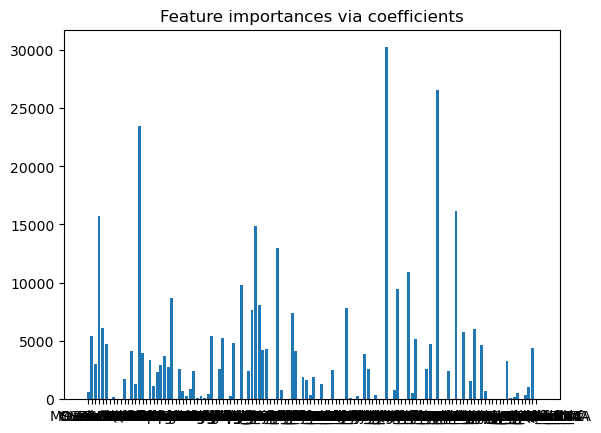

In [197]:
from sklearn.linear_model import LassoCV
# 
lasso = LassoCV().fit(X_var, y)
importance = np.abs(lasso.coef_) # Extract coefficients
plt.bar(height=importance, x=selected_columns)
plt.title("Feature importances via coefficients")
plt.show()

In [198]:
# Make list of values
importance_features = list(zip(selected_columns, importance))

# Sort the list of tuples by values in descending order and select top 5 tuples
top5 = sorted(importance_features, key=lambda x: x[1], reverse=True)[:5]

# Extract column names from selected tuples
top5_features = [t[0] for t in top5]
top5_features

['KitchenQual_Ex',
 'BsmtQual_Ex',
 'GrLivArea',
 'BsmtExposure_Gd',
 'OverallQual']

In [128]:
importance.mean()

2909.7897231579577

In [129]:
# Now I can remove all the features with 0 importance, 
# but also I'm gonna remove those features below 1000 importance,
# since that amount of importance in this context would be practically irrelevant,
# since the mean is 3k.

# Make list of values
importance_features = list(zip(selected_columns, importance))

# Sort the list of tuples by values in descending order and select top 10 tuples
selected_features_lasso = sorted(importance_features, key=lambda x: x[1], reverse=True)
print("Total Features: ", len(importance_features))
print("Features with 0 importance: ", len([(x) for x in selected_features_lasso if x[1] == 0]))
print("Features that are > 0 and < 1000: ", len([(x) for x in selected_features_lasso if x[1]!= 0 and x[1] < 1000]))
selected_features_lasso = [(x) for x in selected_features_lasso if x[1] > 1000]

# Extract column names from selected tuples
#top10_features = [t[0] for t in top10]
selected_features_names_lasso = [t[0] for t in selected_features_lasso]
selected_features_names_lasso

Total Features:  124
Features with 0 importance:  42
Features that are > 0 and < 1000:  25


['KitchenQual_Ex',
 'BsmtQual_Ex',
 'GrLivArea',
 'BsmtExposure_Gd',
 'OverallQual',
 'Neighborhood_Edwards',
 'Condition1_Norm',
 'SaleType_New',
 'LotConfig_CulDSac',
 'Functional_Typ',
 'GarageCars',
 'Neighborhood_Gilbert',
 'ExterQual_TA',
 'Neighborhood_CollgCr',
 'HouseStyle_1Story',
 'OverallCond',
 'BsmtFinType1_GLQ',
 'BsmtExposure_No',
 'MasVnrArea',
 'MSSubClass',
 'MSZoning_RM',
 'SaleCondition_Abnorml',
 'LandContour_Lvl',
 'MasVnrType_None',
 'YearBuilt',
 'BsmtFinType1_Unf',
 'GarageCond_NA',
 'Neighborhood_OldTown',
 'Neighborhood_NAmes',
 '2ndFlrSF',
 'HouseStyle_2Story',
 'BsmtFullBath',
 'Foundation_PConc',
 'TotRmsAbvGrd',
 'FullBath',
 'GarageType_NA',
 'LotArea',
 'KitchenAbvGr',
 'Fireplaces',
 'MasVnrType_BrkFace',
 'WoodDeckSF',
 'MSZoning_RL',
 'HeatingQC_Ex',
 'Exterior2nd_Plywood',
 'LandSlope_Gtl',
 'ScreenPorch',
 'BsmtCond_TA',
 'BedroomAbvGr',
 'RoofStyle_Hip',
 'Exterior1st_Plywood',
 'TotalBsmtSF',
 'Exterior1st_HdBoard',
 'BsmtFinType1_BLQ',
 'LowQua

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_var_df[selected_features_names_lasso], y, test_size=0.2, random_state=0)

In [131]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1168, 57), (1168,), (292, 57), (292,))

In [132]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train);

In [133]:
# Evaluate the performance of the model
y_pred = forest.predict(X_test)
print(y_test.shape, y_test.shape)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1).astype(np.int64)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

(292,) (292,)
Mean Squared Error: 976850927.14
Mean Absolute Error: 17777.81


In [134]:
results[0:50], results[50:100], results[100:150], results[150:200]

(    Original  Predicted
 0     200624     219144
 1     133000     150230
 2     110000     107346
 3     192000     231766
 4      88000      91345
 5      85000     108684
 6     282922     249122
 7     141000     123537
 8     745000     526150
 9     148800     154728
 10    208900     218122
 11    136905     147125
 12    225000     233965
 13    123000     123662
 14    119200     139167
 15    145000     148074
 16    190000     218679
 17    123600     117807
 18    149350     142338
 19    155000     179793
 20    166000     123433
 21    144500     142623
 22    110000     124017
 23    174000     172923
 24    185000     190902
 25    168000     210743
 26    177500     171030
 27     84500      81547
 28    320000     318249
 29    118500     119479
 30    110000     141628
 31    213000     190147
 32    156000     138619
 33    250000     302219
 34    372500     340530
 35    175000     187943
 36    277500     294826
 37    112500     127969
 38    263000     228898


In [135]:
# Lets do some more testing
X_kf = np.array(X_var_df[selected_features_names_lasso])
kf = KFold(n_splits=10)
rf_output = []
lr_output = []
for train, test in kf.split(X_kf):
    X_train, X_test, y_train, y_test = X_kf[train], X_kf[test], y[train], y[test]
    rf = testModel(X_train, X_test, y_train, y_test, RandomForestRegressor)
    lr = testModel(X_train, X_test, y_train, y_test, LinearRegression)
    rf_output.append(rf)
    lr_output.append(lr)
    print("Random Forest: ", rf)
    print("Linear Regression: ", lr)

Random Forest:  [739237740.0904671, 18227.838493150684]
Linear Regression:  [470262915.17867047, 16711.30082393628]
Random Forest:  [743833913.8842784, 18105.539269406392]
Linear Regression:  [651387583.8905977, 18503.475778740863]
Random Forest:  [501698803.4364605, 16443.99569797782]
Linear Regression:  [602426807.411029, 18289.650667361322]
Random Forest:  [1475938392.09453, 18769.633972602736]
Linear Regression:  [1612822122.927882, 21132.21972450132]
Random Forest:  [1125650126.7723234, 20063.035707762556]
Linear Regression:  [1159204830.9135451, 19055.71563121059]
Random Forest:  [600189701.791422, 13944.115593607308]
Linear Regression:  [676591574.3230689, 15987.02365515766]
Random Forest:  [525516163.02896243, 15930.775443574692]
Linear Regression:  [698262495.3088964, 18206.782810517674]
Random Forest:  [508281451.4960943, 15731.240799086756]
Linear Regression:  [580303791.9605913, 16281.638443683554]
Random Forest:  [1332349591.8592994, 19182.180903457273]
Linear Regression: 

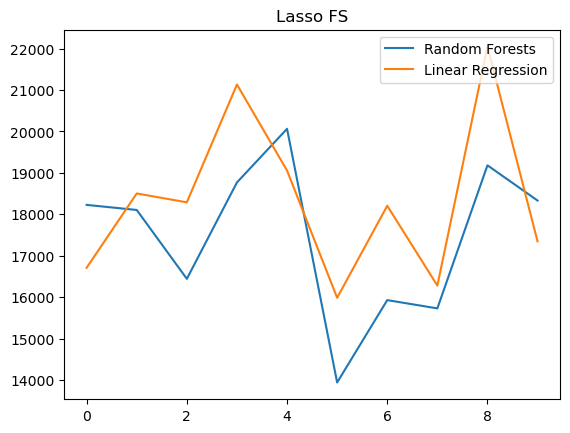

In [136]:
results = pd.DataFrame(
    pd.concat(
        (pd.DataFrame(rf_output)[1], pd.DataFrame(lr_output)[1]), 
        axis=1)
);
fig, ax = plt.subplots()
ax.plot(range(len(results)), results, label=["Random Forests", "Linear Regression"]);
ax.set_title(label="Lasso FS");
ax.legend(loc='upper right');

- Now, by using less than half features (57), we've achieved basically the same performance.
- Let's try ElasticNet.
- The User Guide says: Elastic-net is useful when there are multiple features that are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

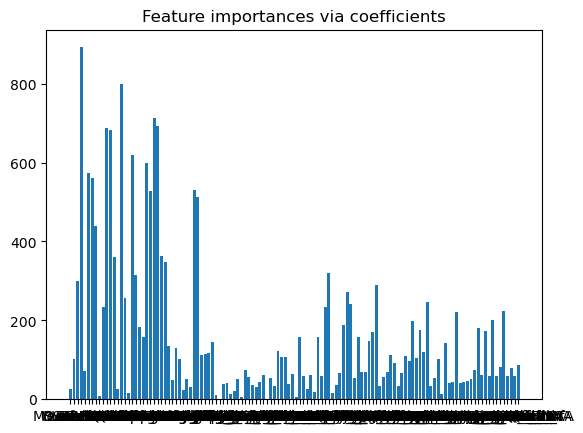

In [202]:
from sklearn.linear_model import ElasticNetCV
# Lasso adds a penalty to different coefficients to reduce their freedom which helps it not fit the noise.
# Higher penalty, less overfit
# If it shrinks a feature to 0 means it doesn't add anything to the output.

elastic = ElasticNetCV().fit(X_var_df, y)
importance = np.abs(elastic.coef_) # Extract coefficients
plt.bar(height=importance, x=X_var_df.columns)
plt.title("Feature importances via coefficients")
plt.show()

In [203]:
# Make list of values
importance_features = list(zip(selected_columns, importance))

# Sort the list of tuples by values in descending order and select top 5 tuples
top5 = sorted(importance_features, key=lambda x: x[1], reverse=True)[:5]

# Extract column names from selected tuples
top5_features = [t[0] for t in top5]
top5_features

['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']

In [138]:
importance.mean()

163.1020466780143

In [139]:
# This time we have 1 feature with 0 coef
# So I was thinking on setting an arbitrary threshold to reduce the features and see how it performs
pd.DataFrame(importance > 100).sum()

0    59
dtype: int64

In [140]:
# Make list of values
importance_features = list(zip(selected_columns, importance))
selected_features_elastic = sorted(importance_features, key=lambda x: x[1], reverse=True)
selected_features_elastic = [(x) for x in selected_features_elastic if x[1] > 100]
selected_features_names_elastic = [t[0] for t in selected_features_elastic]
selected_features_names_elastic

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'Fireplaces',
 'GarageYrBlt',
 'BsmtFinSF1',
 'WoodDeckSF',
 '2ndFlrSF',
 'OpenPorchSF',
 'ExterQual_TA',
 'HalfBath',
 'LotArea',
 'KitchenQual_TA',
 'Foundation_PConc',
 'BsmtFullBath',
 'BsmtQual_TA',
 'HeatingQC_Ex',
 'ExterQual_Gd',
 'BsmtUnfSF',
 'GarageFinish_Unf',
 'BsmtFinType1_GLQ',
 'GarageFinish_Fin',
 'MasVnrType_None',
 'Foundation_CBlock',
 'BedroomAbvGr',
 'GarageType_Attchd',
 'BsmtQual_Ex',
 'GarageType_Detchd',
 'KitchenQual_Gd',
 'HeatingQC_TA',
 'KitchenAbvGr',
 'Exterior2nd_VinylSd',
 'Exterior1st_VinylSd',
 'KitchenQual_Ex',
 'LotShape_Reg',
 'BsmtExposure_No',
 'EnclosedPorch',
 'ScreenPorch',
 'HouseStyle_2Story',
 'BsmtQual_Gd',
 'LotShape_IR1',
 'MSZoning_RM',
 'MSZoning_RL',
 'SaleType_New',
 'SaleCondition_Partial',
 'RoofStyle_Hip',
 'RoofStyle_Gable',
 'MasVnrType_Stone',
 'PoolArea',
 'BsmtE

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_var_df[selected_features_names_elastic], y, test_size=0.2, random_state=0)

In [142]:
X_train.shape, y_train.shape

((1168, 59), (1168,))

In [143]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train);

In [144]:
# Evaluate the performance of the model
y_pred = forest.predict(X_test)
results = pd.DataFrame(
    np.concatenate(
        (
            y_test.to_numpy().reshape(len(y_test), 1),
            y_pred.reshape(len(y_pred), 1).astype(np.int64)

        ), axis=1),
    columns=["Original", "Predicted"]
    )

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:0.2f}')
print(f'Mean Absolute Error: {mae:0.2f}')

Mean Squared Error: 1066134250.87
Mean Absolute Error: 17632.39


In [145]:
results[0:50], results[50:100], results[100:150], results[150:200]

(    Original  Predicted
 0     200624     215588
 1     133000     139428
 2     110000     109398
 3     192000     225324
 4      88000      89978
 5      85000     119787
 6     282922     261049
 7     141000     122292
 8     745000     519412
 9     148800     150975
 10    208900     195394
 11    136905     143504
 12    225000     225903
 13    123000     127424
 14    119200     122971
 15    145000     145433
 16    190000     223082
 17    123600     116427
 18    149350     127585
 19    155000     189676
 20    166000     133326
 21    144500     142298
 22    110000     118838
 23    174000     170397
 24    185000     181603
 25    168000     209452
 26    177500     171154
 27     84500      81225
 28    320000     326136
 29    118500     119738
 30    110000     133575
 31    213000     198392
 32    156000     141596
 33    250000     291945
 34    372500     340593
 35    175000     185811
 36    277500     292312
 37    112500     124491
 38    263000     231173


In [146]:
# Lets do some more testing
X_kf = np.array(X_var_df[selected_features_names_elastic])
kf = KFold(n_splits=10)
rf_output = []
lr_output = []
for train, test in kf.split(X_kf):
    X_train, X_test, y_train, y_test = X_kf[train], X_kf[test], y[train], y[test]
    rf = testModel(X_train, X_test, y_train, y_test, RandomForestRegressor)
    lr = testModel(X_train, X_test, y_train, y_test, LinearRegression)
    rf_output.append(rf)
    lr_output.append(lr)
    print("Random Forest: ", rf)
    print("Linear Regression: ", lr)

Random Forest:  [689521108.0776362, 17377.32308219178]
Linear Regression:  [575499897.3354281, 18082.574451573124]
Random Forest:  [691023219.9700897, 18008.206643835616]
Linear Regression:  [746182965.3980043, 19734.046707403362]
Random Forest:  [514196416.52675474, 16064.69534246575]
Linear Regression:  [604777412.3540336, 18023.257778028223]
Random Forest:  [1799058214.70672, 20022.94205479452]
Linear Regression:  [1935315200.3081117, 23739.563211664212]
Random Forest:  [1112358378.0364525, 19385.07746575342]
Linear Regression:  [1424358288.9786398, 22640.521483692526]
Random Forest:  [638958402.680811, 15271.23917808219]
Linear Regression:  [826037271.8370855, 17694.93125852638]
Random Forest:  [575587293.4707917, 15966.601369863016]
Linear Regression:  [673964080.8480626, 17876.329325549534]
Random Forest:  [587777509.3719951, 16998.838013698627]
Linear Regression:  [652573499.47788, 17444.381159247856]
Random Forest:  [1389396681.160482, 20696.281780821915]
Linear Regression:  [3

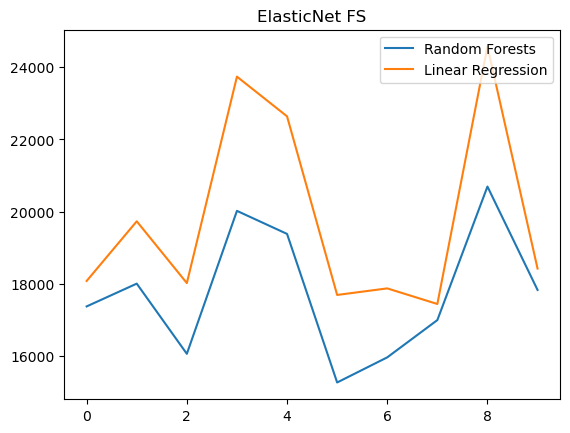

In [147]:
results = pd.DataFrame(
    pd.concat(
        (pd.DataFrame(rf_output)[1], pd.DataFrame(lr_output)[1]), 
        axis=1)
);
fig, ax = plt.subplots()
ax.plot(range(len(results)), results, label=["Random Forests", "Linear Regression"]);
ax.set_title(label="ElasticNet FS");
ax.legend(loc='upper right');

- The performance went down, so that means the subset we chose from applying ElasticNet had probably some important missing features.
- So far we've tried many techniques with almost the same models, we haven't done any significant modification to the features, so far we've done only selection, and also haven't touched too much the alphas and tolerance of Ridge and Lasso.
- We've been seeing some important features repeating from technique to technique, so now I wanna go back to a previous step, and check if there are some relation between the most important features, and the ones that we left behind in the data imputation step, because they have too many missing values.

In [148]:
missing_values = X.columns[X.isnull().sum() > 0].tolist()
X[missing_values].isnull().sum()

LotFrontage     259
Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64

- Let's take into account LotFrontage: "Linear feet of street connected to property" and see how it behaves with the price.

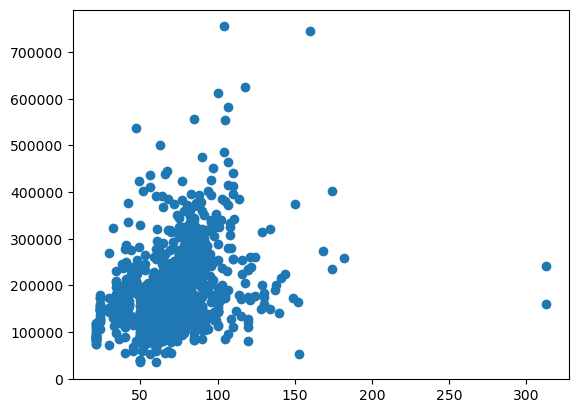

In [149]:
X1data = np.array(X['LotFrontage'])
fig, ax = plt.subplots()
ax.scatter(X1data, y);

- It doesn't look bad. We could work it out and maybe get a little bit performance improvement.
- Now let's look at this mysterious feature: MiscFeature

MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

In [150]:
X['MiscFeature'].unique(), X['MiscFeature'].value_counts()

(array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object),
 Shed    49
 Gar2     2
 Othr     2
 TenC     1
 Name: MiscFeature, dtype: int64)

- This one, interestingly, we can encode the categories into new fetures that might help gain some extra performance.
- Sadly we only have 49 values for Shed over 100 SF.
- 1460*0.05 = 73 and we only have 49 values, so If we added this feature before, it would have been filtered in the variance threshold step.
- Adding feature like this would cause the model to become too complex, so it's not good idea.
- Let's analyze other features then.

In [151]:
# FireplaceQu Gd and TA could be a feature that we could add.
X['FireplaceQu'].unique(), X['FireplaceQu'].value_counts()

(array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object),
 Gd    380
 TA    313
 Fa     33
 Ex     24
 Po     20
 Name: FireplaceQu, dtype: int64)

In [152]:
# Fence MnPrv could also be another feature to add
X['Fence'].unique(), X['Fence'].value_counts()

(array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object),
 MnPrv    157
 GdPrv     59
 GdWo      54
 MnWw      11
 Name: Fence, dtype: int64)

In [153]:
# Add more features.
# Luckily these features are categories, so no scaling is needed.
X_extrafeatures = pd.get_dummies(X[['FireplaceQu', 'Fence']])
X_extrafeatures.columns

Index(['FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po',
       'FireplaceQu_TA', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv',
       'Fence_MnWw'],
      dtype='object')

 - Add the new features with the rest

In [154]:
# And then we add the encoded features with more than 71 positive obvservations
X_var_df_2 = pd.concat([X_var_df, X_extrafeatures[['FireplaceQu_Gd', 'FireplaceQu_TA', 'Fence_MnPrv']]], axis=1)
X_var_df.shape, X_var_df_2.shape

((1460, 124), (1460, 127))

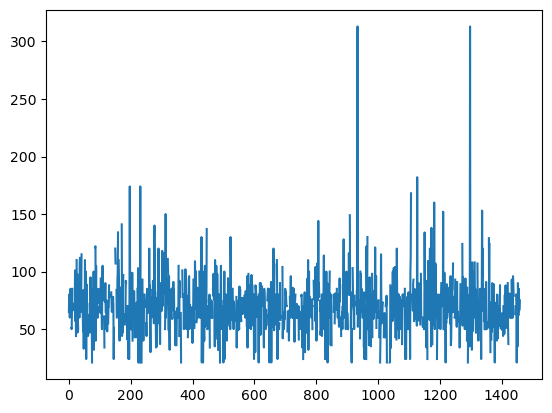

In [155]:
# But with LotFrontage we will need imputing and then scaling.
X['LotFrontage'].plot();

- Can we base this feature missing observations on other related feature for imputation?
- Well, we have LotArea, let's look at it.

LotArea: Lot size in square feet

- So it looks like it can be realated to LotFrontage (Linear feet of street connected to property)
- Let's use SimpleImputer to fill the values with some data.

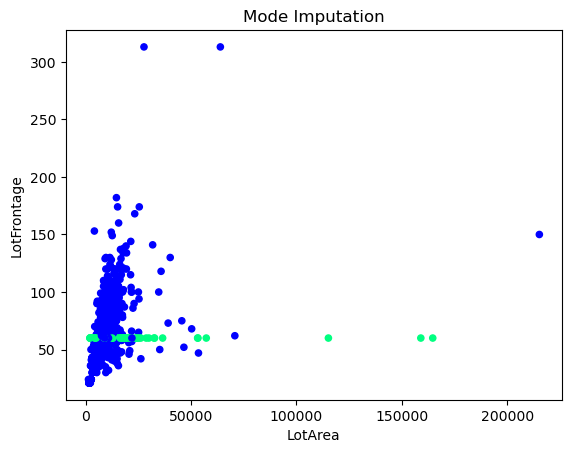

In [156]:
df_mode = X.copy(deep=True)
mode_imputer = SimpleImputer(strategy="most_frequent")
df_mode['LotFrontage'] = mode_imputer.fit_transform(df_mode['LotFrontage'].values.reshape(-1,1))

fig = plt.Figure()
null_values = X["LotFrontage"].isnull() 
fig = df_mode.plot(x="LotArea", y="LotFrontage", kind="scatter", c=null_values, cmap='winter', colorbar=False, title='Mode Imputation')

- Doesn't looks so good, and I actually think that they correlate, so let's try a more complex method.

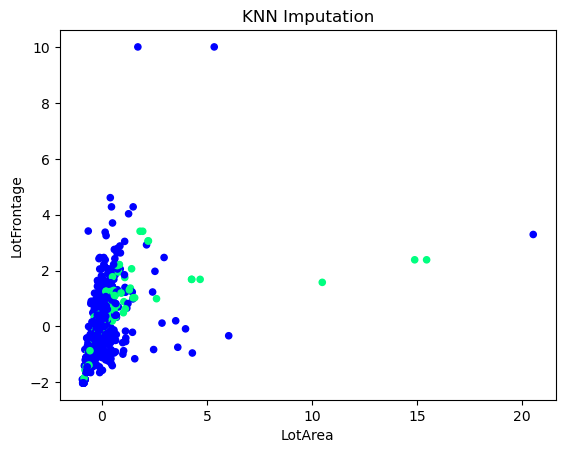

In [157]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

df_knn = X.filter(['LotFrontage','LotArea'], axis=1).copy()

# We use the same scaler from before
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

fig = plt.Figure()
null_values = X["LotFrontage"].isnull() 
fig = df_knn_imputed.plot(x="LotArea", y="LotFrontage", kind="scatter", c=null_values, cmap='winter', title='KNN Imputation', colorbar=False)
    

- Now this loos a lot better, we see data spreading from the bottom to the top, wich means that the  LotArea actually affects the LotFrontage in some way.

- Does a big LotArea means a big LotFrontage? Not necesarily, 
- but it should be related if we assume all lots connect one of its faces to a street.
- So lots with bigger area and normal frontage could mean that the lot is longer but has the same frontage than others shorter lots.
- Kinda remembers me this picture of an Australian house.
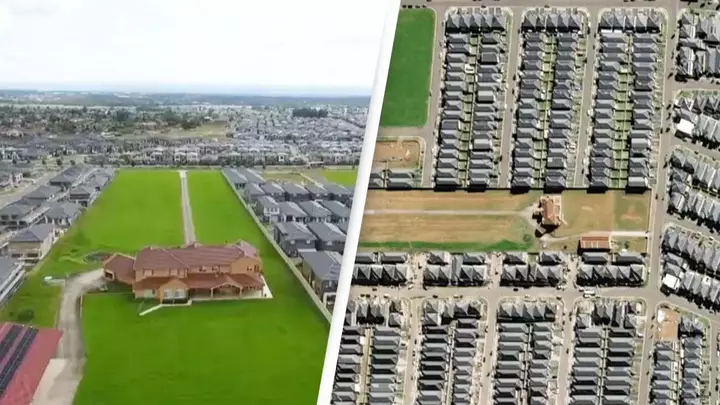

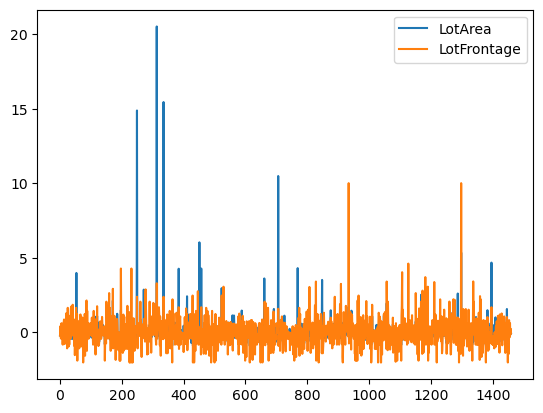

In [158]:
df_knn_imputed[['LotArea', 'LotFrontage']].plot();

In [159]:
scaled_knn_imputed = scaler.fit_transform(df_knn_imputed[[ 'LotFrontage']])
print(X_var_df_2.shape)
X_var_df_2 = pd.concat([X_var_df_2, pd.DataFrame(scaled_knn_imputed, columns=['LotFrontage'])], axis=1)
print(X_var_df_2.shape)

(1460, 127)
(1460, 128)


In [160]:
X_var_df_2

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageFinish_RFn,GarageFinish_Unf,GarageQual_NA,GarageQual_TA,GarageCond_NA,GarageCond_TA,FireplaceQu_Gd,FireplaceQu_TA,Fence_MnPrv,LotFrontage
0,-1.730865,0.073375,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.575425,-0.288653,-0.944591,...,1.0,0.0,0.0,1.0,0.0,1.0,0,0,0,-0.259652
1,-1.728492,-0.872563,-0.091886,-0.071836,2.179628,0.156734,-0.429577,1.171992,-0.288653,-0.641228,...,1.0,0.0,0.0,1.0,0.0,1.0,0,1,0,0.367846
2,-1.726120,0.073375,0.073480,0.651479,-0.517200,0.984752,0.830215,0.092907,-0.288653,-0.301643,...,1.0,0.0,0.0,1.0,0.0,1.0,0,1,0,-0.134153
3,-1.723747,0.309859,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.499274,-0.288653,-0.061670,...,0.0,1.0,0.0,1.0,0.0,1.0,1,0,0,-0.468818
4,-1.721374,0.073375,0.375148,1.374795,-0.517200,0.951632,0.733308,0.463568,-0.288653,-0.174865,...,1.0,0.0,0.0,1.0,0.0,1.0,0,1,0,0.535179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.973018,-0.288653,0.873321,...,1.0,0.0,0.0,1.0,0.0,1.0,0,1,0,-0.385152
1456,1.723747,-0.872563,0.266407,-0.071836,0.381743,0.222975,0.151865,0.759659,0.722112,0.049262,...,0.0,1.0,0.0,1.0,0.0,1.0,0,1,1,0.577012
1457,1.726120,0.309859,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.369871,-0.288653,0.701265,...,1.0,0.0,0.0,1.0,0.0,1.0,1,0,0,-0.217819
1458,1.728492,-0.872563,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.865548,6.092188,-1.284176,...,0.0,1.0,0.0,1.0,0.0,1.0,0,0,0,-0.134153


In [161]:
# Test to see if we are overfitting or not
X_train, X_test, y_train, y_test = train_test_split(X_var_df_2, y, test_size=0.2, random_state=0)
print('RF: Train & Train', testModel(X_train, X_train, y_train, y_train, RandomForestRegressor))
print('RF: Train & Test', testModel(X_train, X_test, y_train, y_test, RandomForestRegressor))
print('LR: Train & Train', testModel(X_train, X_train, y_train, y_train, LinearRegression))
print('LR: Train & Test', testModel(X_train, X_test, y_train, y_test, LinearRegression))

RF: Train & Train [120479732.79062594, 6576.126652397262]
RF: Train & Test [1180378021.6221554, 17885.39061643836]
LR: Train & Train [617044122.3818493, 15141.392123287671]
LR: Train & Test [2109444465.30137, 20391.76712328767]


- We still have the 6.6k error on RF. I don't think we are overfitting.
- Now I wanna try a method I've never used and everyone is talking about, which is XGBoost.

In [207]:
test = pd.read_csv("data/test.csv")
test_dataset = test
# Separate features
# Separate data Xm will be X without features with missing values
"""Xm = test_dataset.drop(columns=missing_values)
print(Xm.columns)

# Select the numerical columns
numerical_columns = Xm.select_dtypes(include=['int', 'float']).columns
X_num = Xm.loc[:, numerical_columns]

# Select the categorical columns
categorical_columns = Xm.select_dtypes(include=['object']).columns
X_cat = Xm.loc[:, categorical_columns]"""
test_missing_values = test_dataset.columns[test_dataset.isnull().sum() > 0].tolist()
test_dataset[test_missing_values].isnull().sum()

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [210]:
Xm = test_dataset.drop(columns=missing_values)

# Select the numerical columns
numerical_columns = Xm.select_dtypes(include=['int', 'float']).columns
X_num = Xm.loc[:, numerical_columns]

# Select the categorical columns
categorical_columns = Xm.select_dtypes(include=['object']).columns
X_cat = Xm.loc[:, categorical_columns]

Xm.shape, X_num.shape, X_cat.shape

((1459, 74), (1459, 36), (1459, 38))

In [212]:
X_num = scaler.fit_transform(X_num)
X_cat = pd.get_dummies(X_cat)

In [213]:
X_merged = pd.concat([pd.DataFrame(X_num, columns=numerical_columns), pd.DataFrame(X_cat)], axis=1)
X_merged.shape

(1459, 254)

In [217]:
X_new_test = X_merged[[x1 for x1 in X_var_df_2.columns if x1 in X_merged.columns]]
X_new_test

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,Electrical_FuseA,Electrical_SBrkr,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_TA,GarageCond_TA
0,-1.730864,-0.874711,0.363929,-0.751101,0.400766,-0.340945,-1.072885,0.063273,0.517171,-0.650396,...,0,1,1,0,0,0,0,1,1,1
1,-1.728490,-0.874711,0.897861,-0.054877,0.400766,-0.439695,-1.214908,1.063027,-0.297800,-0.339262,...,0,1,1,0,0,0,0,1,1,1
2,-1.726115,0.061351,0.809646,-0.751101,-0.497418,0.844059,0.678742,0.772989,-0.297800,-0.954667,...,0,1,1,0,0,1,0,0,1,1
3,-1.723741,0.061351,0.032064,-0.054877,0.400766,0.876976,0.678742,0.357706,-0.297800,-0.526857,...,0,1,1,0,0,1,0,0,1,1
4,-1.721367,1.465443,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.387166,-0.297800,1.058554,...,0,1,1,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.721367,2.401505,-1.591330,-1.447325,1.298950,-0.044694,-0.646813,-0.965046,-0.297800,-0.018977,...,0,1,0,0,0,0,0,0,0,0
1455,1.723741,2.401505,-1.599808,-1.447325,-0.497418,-0.044694,-0.646813,-0.411336,-0.297800,-0.595490,...,0,1,0,0,0,0,0,1,1,1
1456,1.726115,-0.874711,2.055150,-0.751101,1.298950,-0.373861,0.584059,1.724403,-0.297800,-1.268089,...,0,1,0,0,1,0,0,1,1,1
1457,1.728490,0.646389,0.125527,-0.751101,-0.497418,0.679475,0.394694,-0.224568,-0.297800,0.047368,...,0,1,0,0,0,0,0,0,0,0


In [239]:
X_new_test.columns[X_merged[X_new_test.columns].isnull().sum() > 0]

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
       'BsmtHalfBath', 'GarageCars', 'GarageArea', 'MasVnrArea',
       'GarageYrBlt'],
      dtype='object')

In [240]:
X_new_test = X_new_test[[x1 for x1 in X_new_test.columns if x1 not in X_new_test.columns[X_merged[X_new_test.columns].isnull().sum() > 0]]]

In [243]:
X_new_test.columns[X_merged[X_new_test.columns].isnull().sum() > 0]

Index([], dtype='object')

In [253]:
X_var_df_2[X_new_test.columns]

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,1stFlrSF,2ndFlrSF,LowQualFinSF,...,Electrical_FuseA,Electrical_SBrkr,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_TA,GarageCond_TA
0,-1.730865,0.073375,-0.207142,0.651479,-0.517200,1.050994,0.878668,-0.793434,1.161852,-0.120242,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,-1.728492,-0.872563,-0.091886,-0.071836,2.179628,0.156734,-0.429577,0.257140,-0.795163,-0.120242,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,-1.726120,0.073375,0.073480,0.651479,-0.517200,0.984752,0.830215,-0.627826,1.189351,-0.120242,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,-1.723747,0.309859,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.521734,0.937276,-0.120242,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
4,-1.721374,0.073375,0.375148,1.374795,-0.517200,0.951632,0.733308,-0.045611,1.617877,-0.120242,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.542435,0.795198,-0.120242,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1456,1.723747,-0.872563,0.266407,-0.071836,0.381743,0.222975,0.151865,2.355701,-0.795163,-0.120242,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1457,1.726120,0.309859,-0.147810,0.651479,3.078570,-1.002492,1.024029,0.065656,1.844744,-0.120242,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1458,1.728492,-0.872563,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.218982,-0.795163,-0.120242,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [293]:
scaler = StandardScaler()
original_data = np.array(test_dataset['Id']).reshape(-1, 1)
data_to_rescale = np.array(X_new_test['Id']).reshape(-1,1)
scaler.fit(original_data)
print(scaler.inverse_transform(data_to_rescale))

[[1461.]
 [1462.]
 [1463.]
 ...
 [2917.]
 [2918.]
 [2919.]]


In [298]:
model = RandomForestRegressor()
model.fit(X_var_df_2[X_new_test.columns], y)
y_pred = model.predict(X_new_test)
print(y_pred.shape)

results_df = pd.DataFrame(
    np.concatenate(
        (
            scaler.inverse_transform(data_to_rescale).astype(int),
            y_pred.reshape(len(y_pred), 1)

        ), axis=1),
    columns=["Id", "SalePrice"]
    )

results_df.astype(int).to_csv('output.csv')

(1459,)


In [185]:
from xgboost import XGBRegressor
#model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
#model = XGBRegressor()
print('XGB: Train & Test', testModel(X_train, X_test, y_train, y_test, XGBRegressor))

XGB: Train & Test [828185776.3814281, 18307.931787778252]


In [187]:
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(mse, mae)

723556586.2706518 16225.332205158391


- I kinda was expecting this to outperform the others right off the shelf, it didn't, so we still have some work for trying methods for selecting better features, creating new features and using different classifiers, like ensemble methods for example.
- By adjusting some parameters we can achieve better results, but still not better as some iterations where the other RF models achieved about 15k.

In [193]:
X_var_df_2.shape

(1460, 128)

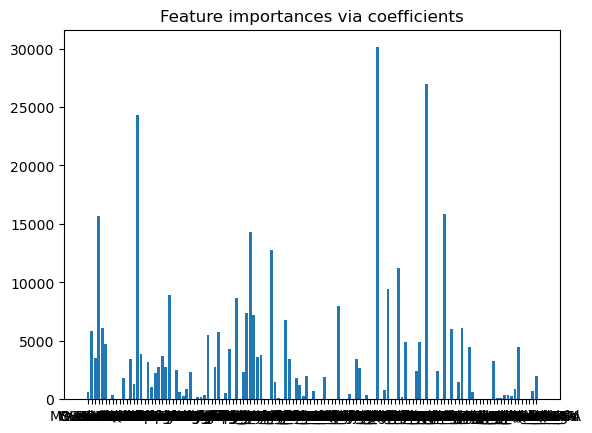

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,OverallQual,FullBath,GrLivArea,MoSold,BsmtFinType1_Unf,OverallCond,2ndFlrSF,HeatingQC_TA,MasVnrType_None,YearBuilt,...,LotShape_IR1,YearRemodAdd,HouseStyle_1Story,YrSold,BsmtFinSF1,TotalBsmtSF,RoofStyle_Gable,BsmtExposure_No,LotConfig_Inside,BedroomAbvGr
1,15590.241186,14952.158952,13089.286593,9898.387585,9124.150983,6282.86743,5650.47211,5397.634375,5106.73748,4503.150564,...,717.811947,556.497078,518.739814,360.328581,335.166407,329.018258,306.332039,298.138787,116.977187,22.204457


In [189]:
# Apply Lasso
lasso = X_var_df_2().fit(X_var_df_2, y)
importance = np.abs(lasso.coef_) # Extract coefficients
plt.bar(height=importance, x=X_var_df_2.columns)
plt.title("Feature importances via coefficients")
plt.show()
top_f_coef = sorted(importance_features, key=lambda x: x[1], reverse=True)
top_f_df = pd.DataFrame(top_f_importance).T
top_f_df